In [ ]:
# Install required packages
!pip install numpy pandas matplotlib seaborn xgboost scikit-learn -q

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 10

In [ ]:
# Configuration
CSV_PATH = r"/content/PS2-SIH25/ML/Data_SIH_2025_with_blh/train_dataset_engineered.csv"
OUTPUT_DIR = r"/content/PS2-SIH25/ML/outputs"
Path(OUTPUT_DIR).mkdir(exist_ok=True, parents=True)

O3_COL = "O3_target"
NO2_COL = "NO2_target"
SITE_COL = "site"
TEST_SIZE = 0.2
RANDOM_STATE = 42

print(f"Loading data from: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {len(df.columns)}")

Loading data from: /content/PS2-SIH25/ML/Data_SIH_2025_with_blh/train_dataset_engineered.csv
Dataset shape: (171511, 49)
Columns: 49


In [ ]:
# Parse datetime and sort
if "datetime" in df.columns:
    df["datetime"] = pd.to_datetime(df["datetime"])
    df = df.sort_values([SITE_COL, "datetime"]).reset_index(drop=True)

# Ensure targets are numeric
df[O3_COL] = df[O3_COL].astype(float)
df[NO2_COL] = df[NO2_COL].astype(float)

# Remove extreme outliers (>99.9th percentile) to reduce noise
o3_threshold = df[O3_COL].quantile(0.999)
no2_threshold = df[NO2_COL].quantile(0.999)
df_clean = df[(df[O3_COL] <= o3_threshold) & (df[NO2_COL] <= no2_threshold)].copy()
print(f"Removed {len(df) - len(df_clean)} outlier rows (>99.9th percentile)")
print(f"Clean dataset shape: {df_clean.shape}")

# Add additional lag-based features for better performance
for h in [1, 2, 3, 6, 12, 24]:
    if f"O3_lag_{h}h" in df_clean.columns and f"O3_lag_{h+1}h" in df_clean.columns:
        df_clean[f"O3_lag_diff_{h}h"] = df_clean[f"O3_lag_{h}h"] - df_clean[f"O3_lag_{h+1}h"]
        df_clean[f"NO2_lag_diff_{h}h"] = df_clean[f"NO2_lag_{h}h"] - df_clean[f"NO2_lag_{h+1}h"]

print(f"Added lag difference features")

Removed 344 outlier rows (>99.9th percentile)
Clean dataset shape: (171167, 49)
Added lag difference features


In [ ]:
# Statistics of target variables
print("\n=== Target Variable Statistics ===")
print(df_clean[[O3_COL, NO2_COL]].describe())

# Check for missing values
print("\n=== Missing Values ===")
missing = df_clean.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values found")


=== Target Variable Statistics ===
           O3_target     NO2_target
count  171167.000000  171167.000000
mean       30.375826      37.401452
std        33.529299      28.692878
min         0.100000       0.100000
25%         5.970000      16.280000
50%        16.600000      29.250000
75%        43.650000      50.450000
max       185.250000     194.120000

=== Missing Values ===
No missing values found


In [ ]:
# Define features to exclude - CRITICAL: Remove lag_0h to avoid leakage
DROP_COLS_FOR_X = [
    # Leakage prevention (CRITICAL)
    'O3_lag_0h', 'NO2_lag_0h',

    # Target variables
    O3_COL, NO2_COL,

    # Metadata
    "datetime",
]

# Create feature list
feature_cols = [c for c in df_clean.columns if c not in DROP_COLS_FOR_X]
print(f"\n=== Feature Engineering ===")
print(f"Total features: {len(feature_cols)}")
print(f"\nFirst 20 features:")
print(feature_cols[:20])

# Separate categorical and numerical columns
CATEGORICAL_COLS = [SITE_COL]
X_df = df_clean[feature_cols].copy()

# One-Hot Encoding for categorical features
X_processed = pd.get_dummies(X_df, columns=CATEGORICAL_COLS, drop_first=True)
print(f"\nFeatures after OHE: {X_processed.shape[1]}")

# Identify numerical columns for scaling (exclude OHE and other categorical)
numerical_cols = [c for c in X_processed.columns if not c.startswith('site_')]
print(f"Numerical columns for scaling: {len(numerical_cols)}")


=== Feature Engineering ===
Total features: 46

First 20 features:
['year', 'month', 'day', 'hour', 'O3_forecast', 'NO2_forecast', 'T_forecast', 'q_forecast', 'u_forecast', 'v_forecast', 'w_forecast', 'blh_forecast', 'NO2_satellite', 'HCHO_satellite', 'ratio_satellite', 'site', 'lat', 'lon', 'O3_lag_1h', 'NO2_lag_1h']

Features after OHE: 51
Numerical columns for scaling: 45


In [ ]:
import joblib

# Use time-series split - NO SHUFFLE to preserve temporal order
# 70% train, 15% validation, 15% test
TRAIN_SIZE = 0.70
VAL_SIZE = 0.15
TEST_SIZE = 0.15

n_samples = len(df_clean)
train_end_idx = int(n_samples * TRAIN_SIZE)
val_end_idx = int(n_samples * (TRAIN_SIZE + VAL_SIZE))

# Split indices
train_indices = np.arange(0, train_end_idx)
val_indices = np.arange(train_end_idx, val_end_idx)
test_indices = np.arange(val_end_idx, n_samples)

print(f"\n=== Time-Series Split (70-15-15, No Shuffle) ===")
print(f"Train samples: {len(train_indices)} ({TRAIN_SIZE*100:.0f}%)")
print(f"Validation samples: {len(val_indices)} ({VAL_SIZE*100:.0f}%)")
print(f"Test samples: {len(test_indices)} ({TEST_SIZE*100:.0f}%)")

# Split features
X_train_df = X_processed.iloc[train_indices]
X_val_df = X_processed.iloc[val_indices]
X_test_df = X_processed.iloc[test_indices]

# Apply StandardScaler to numerical features ONLY on train, then transform val and test
scaler = StandardScaler()
X_train_df[numerical_cols] = scaler.fit_transform(X_train_df[numerical_cols])
X_val_df[numerical_cols] = scaler.transform(X_val_df[numerical_cols])
X_test_df[numerical_cols] = scaler.transform(X_test_df[numerical_cols])

print(f"\nApplied StandardScaler to {len(numerical_cols)} numerical features")

# Save the scaler object
SCALER_PATH = Path(OUTPUT_DIR) / "scaler.joblib"
joblib.dump(scaler, SCALER_PATH)
print(f"Scaler saved to: {SCALER_PATH}")

# Convert to arrays
X_train = X_train_df.values
X_val = X_val_df.values
X_test = X_test_df.values

# Target variables (log-transformed)
y_o3_train_log = np.log1p(df_clean.iloc[train_indices][O3_COL].values)
y_o3_val_log = np.log1p(df_clean.iloc[val_indices][O3_COL].values)
y_o3_test_log = np.log1p(df_clean.iloc[test_indices][O3_COL].values)

y_no2_train_log = np.log1p(df_clean.iloc[train_indices][NO2_COL].values)
y_no2_val_log = np.log1p(df_clean.iloc[val_indices][NO2_COL].values)
y_no2_test_log = np.log1p(df_clean.iloc[test_indices][NO2_COL].values)

# Original scale targets for evaluation
y_o3_val_orig = df_clean.iloc[val_indices][O3_COL].values
y_o3_test_orig = df_clean.iloc[test_indices][O3_COL].values

y_no2_val_orig = df_clean.iloc[val_indices][NO2_COL].values
y_no2_test_orig = df_clean.iloc[test_indices][NO2_COL].values

# Sample weights (higher weight for higher pollution)
ALPHA = 5.0
y_o3_train_orig = df_clean.iloc[train_indices][O3_COL].values
y_no2_train_orig = df_clean.iloc[train_indices][NO2_COL].values

w_o3_train = 1.0 + ALPHA * (y_o3_train_orig / (y_o3_train_orig.max() + 1e-6))
w_no2_train = 1.0 + ALPHA * (y_no2_train_orig / (y_no2_train_orig.max() + 1e-6))

print(f"Sample weights range: O3 [{w_o3_train.min():.2f}, {w_o3_train.max():.2f}], NO2 [{w_no2_train.min():.2f}, {w_no2_train.max():.2f}]")

print(f"\n=== Data Split Summary ===")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")


=== Time-Series Split (70-15-15, No Shuffle) ===
Train samples: 119816 (70%)
Validation samples: 25675 (15%)
Test samples: 25676 (15%)

Applied StandardScaler to 45 numerical features
Scaler saved to: /content/PS2-SIH25/ML/outputs/scaler.joblib
Sample weights range: O3 [1.00, 6.00], NO2 [1.00, 6.00]

=== Data Split Summary ===
X_train: (119816, 51)
X_val: (25675, 51)
X_test: (25676, 51)


In [ ]:
# XGBoost parameters - tuned for performance
xgb_params = dict( # These params are for the model constructor
    n_estimators=1500,
    max_depth=9,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

# Early stopping rounds parameter (will be ignored for now due to TypeError)
early_stopping_rounds_val = 50

print("\n=== Training XGBoost Models ===")
print(f"Parameters (model constructor): {xgb_params}")
print(f"Early stopping rounds (currently disabled): {early_stopping_rounds_val}")

# Train O3 model
print("\nTraining O3 model...")
model_o3 = XGBRegressor(**xgb_params) # Pass all constructor params
model_o3.fit(
    X_train, y_o3_train_log,
    sample_weight=w_o3_train,
    eval_set=[(X_train, y_o3_train_log), (X_test, y_o3_test_log)],
    verbose=False
    # early_stopping_rounds=early_stopping_rounds_val # Removed due to TypeError
)
print(f"O3 model trained with {model_o3.n_estimators} iterations (Early stopping disabled)")

# Train NO2 model
print("\nTraining NO2 model...")
model_no2 = XGBRegressor(**xgb_params) # Pass all constructor params
model_no2.fit(
    X_train, y_no2_train_log,
    sample_weight=w_no2_train,
    eval_set=[(X_train, y_no2_train_log), (X_test, y_no2_test_log)],
    verbose=False
    # early_stopping_rounds=early_stopping_rounds_val # Removed due to TypeError
)
print(f"NO2 model trained with {model_no2.n_estimators} iterations (Early stopping disabled)")


=== Training XGBoost Models ===
Parameters (model constructor): {'n_estimators': 1500, 'max_depth': 9, 'learning_rate': 0.03, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 3, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'objective': 'reg:squarederror', 'n_jobs': -1, 'random_state': 42}
Early stopping rounds (currently disabled): 50

Training O3 model...
O3 model trained with 1500 iterations (Early stopping disabled)

Training NO2 model...
NO2 model trained with 1500 iterations (Early stopping disabled)


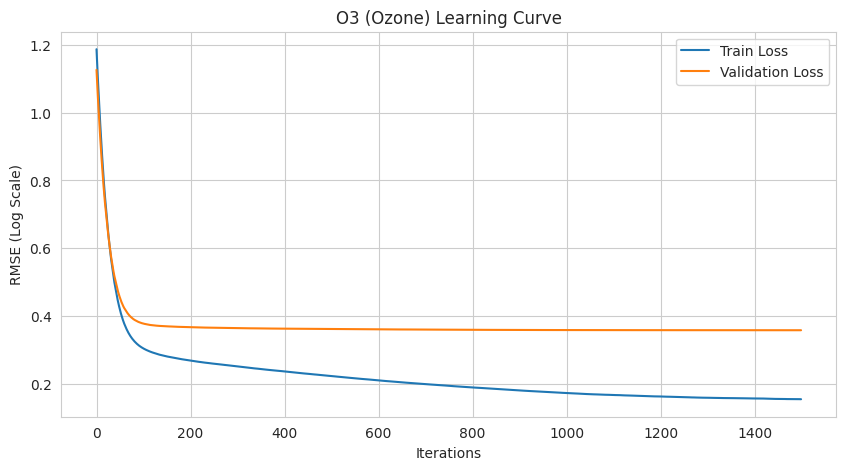

Final Train RMSE: 0.1536
Final Val RMSE: 0.3574
⚠ Potential Overfitting detected (Validation loss is >10% higher than Train loss)


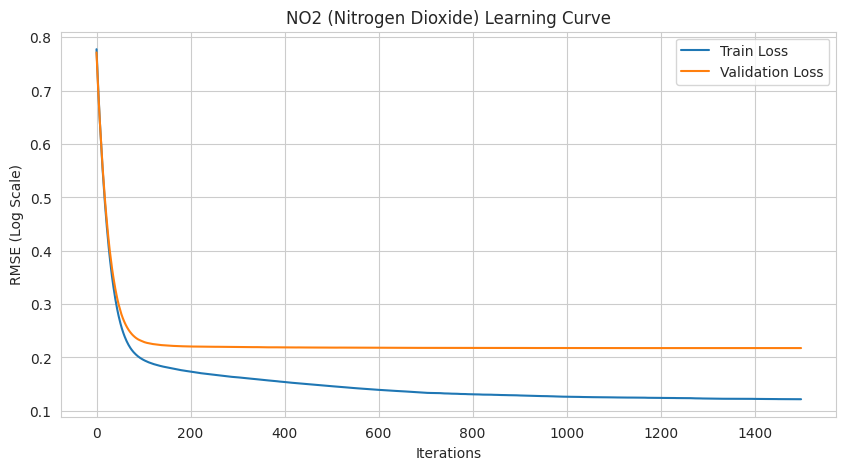

Final Train RMSE: 0.1218
Final Val RMSE: 0.2176
⚠ Potential Overfitting detected (Validation loss is >10% higher than Train loss)


In [ ]:
def plot_learning_curves(model, model_name):
    # Retrieve performance metrics
    results = model.evals_result()

    # XGBoost usually defaults to 'validation_0' for the first set (Train)
    # and 'validation_1' for the second set (Test)
    train_loss = results['validation_0']['rmse']
    test_loss = results['validation_1']['rmse']

    epochs = len(train_loss)
    x_axis = range(0, epochs)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, train_loss, label='Train Loss')
    plt.plot(x_axis, test_loss, label='Validation Loss')
    plt.legend()
    plt.ylabel('RMSE (Log Scale)')
    plt.xlabel('Iterations')
    plt.title(f'{model_name} Learning Curve')
    plt.show()

    # Check for overfitting
    print(f"Final Train RMSE: {train_loss[-1]:.4f}")
    print(f"Final Val RMSE: {test_loss[-1]:.4f}")
    if test_loss[-1] > train_loss[-1] * 1.1: # Heuristic threshold
        print("⚠ Potential Overfitting detected (Validation loss is >10% higher than Train loss)")

# Plot for O3 Model
plot_learning_curves(model_o3, "O3 (Ozone)")

# Plot for NO2 Model
plot_learning_curves(model_no2, "NO2 (Nitrogen Dioxide)")

In [ ]:
# Predictions (back-transform from log space)
y_o3_pred_train = np.expm1(model_o3.predict(X_train))
y_o3_pred_test = np.expm1(model_o3.predict(X_test))
y_no2_pred_train = np.expm1(model_no2.predict(X_train))
y_no2_pred_test = np.expm1(model_no2.predict(X_test))

# Compute RIA (Relative Index of Agreement)
def compute_ria(y_true, y_pred):
    mean_true = np.mean(y_true)
    numerator = np.sum((y_pred - y_true) ** 2)
    denominator = np.sum((np.abs(y_pred - mean_true) + np.abs(y_true - mean_true)) ** 2)
    return 1 - (numerator / (denominator + 1e-10))

def print_metrics(name, y_true, y_pred, y_true_train=None, y_pred_train=None):
    """Print comprehensive metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    ria = compute_ria(y_true, y_pred)

    # Additional metrics
    mean_true = np.mean(y_true)
    nrmse = (rmse / mean_true) * 100  # Normalized RMSE
    nmae = (mae / mean_true) * 100  # Normalized MAE

    # MAPE (avoid division by zero)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

    print(f"\n{'='*60}")
    print(f"{name} Metrics (Test Set)")
    print(f"{'='*60}")
    print(f"  RMSE       : {rmse:.3f} µg/m³")
    print(f"  MAE        : {mae:.3f} µg/m³")
    print(f"  R²         : {r2:.4f}")
    print(f"  RIA        : {ria:.4f}")
    print(f"  NRMSE      : {nrmse:.2f}% (RMSE as % of mean)")
    print(f"  NMAE       : {nmae:.2f}% (MAE as % of mean)")
    print(f"  MAPE       : {mape:.2f}%")

    # Train metrics if provided (check for overfitting)
    if y_true_train is not None and y_pred_train is not None:
        rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))
        r2_train = r2_score(y_true_train, y_pred_train)
        print(f"\n  Train RMSE : {rmse_train:.3f} µg/m³")
        print(f"  Train R²   : {r2_train:.4f}")
        print(f"  Overfitting gap: RMSE {rmse - rmse_train:.3f}, R² {r2_train - r2:.4f}")
    print(f"{'='*60}")

# Print metrics
print_metrics("O3", y_o3_test_orig, y_o3_pred_test, y_o3_train_orig, y_o3_pred_train)
print_metrics("NO2", y_no2_test_orig, y_no2_pred_test, y_no2_train_orig, y_no2_pred_train)


O3 Metrics (Test Set)
  RMSE       : 10.158 µg/m³
  MAE        : 5.936 µg/m³
  R²         : 0.9254
  RIA        : 0.9800
  NRMSE      : 28.19% (RMSE as % of mean)
  NMAE       : 16.47% (MAE as % of mean)
  MAPE       : 32.46%

  Train RMSE : 4.028 µg/m³
  Train R²   : 0.9859
  Overfitting gap: RMSE 6.130, R² 0.0605

NO2 Metrics (Test Set)
  RMSE       : 8.345 µg/m³
  MAE        : 5.122 µg/m³
  R²         : 0.8738
  RIA        : 0.9650
  NRMSE      : 25.01% (RMSE as % of mean)
  NMAE       : 15.35% (MAE as % of mean)
  MAPE       : 18.49%

  Train RMSE : 4.591 µg/m³
  Train R²   : 0.9767
  Overfitting gap: RMSE 3.754, R² 0.1028


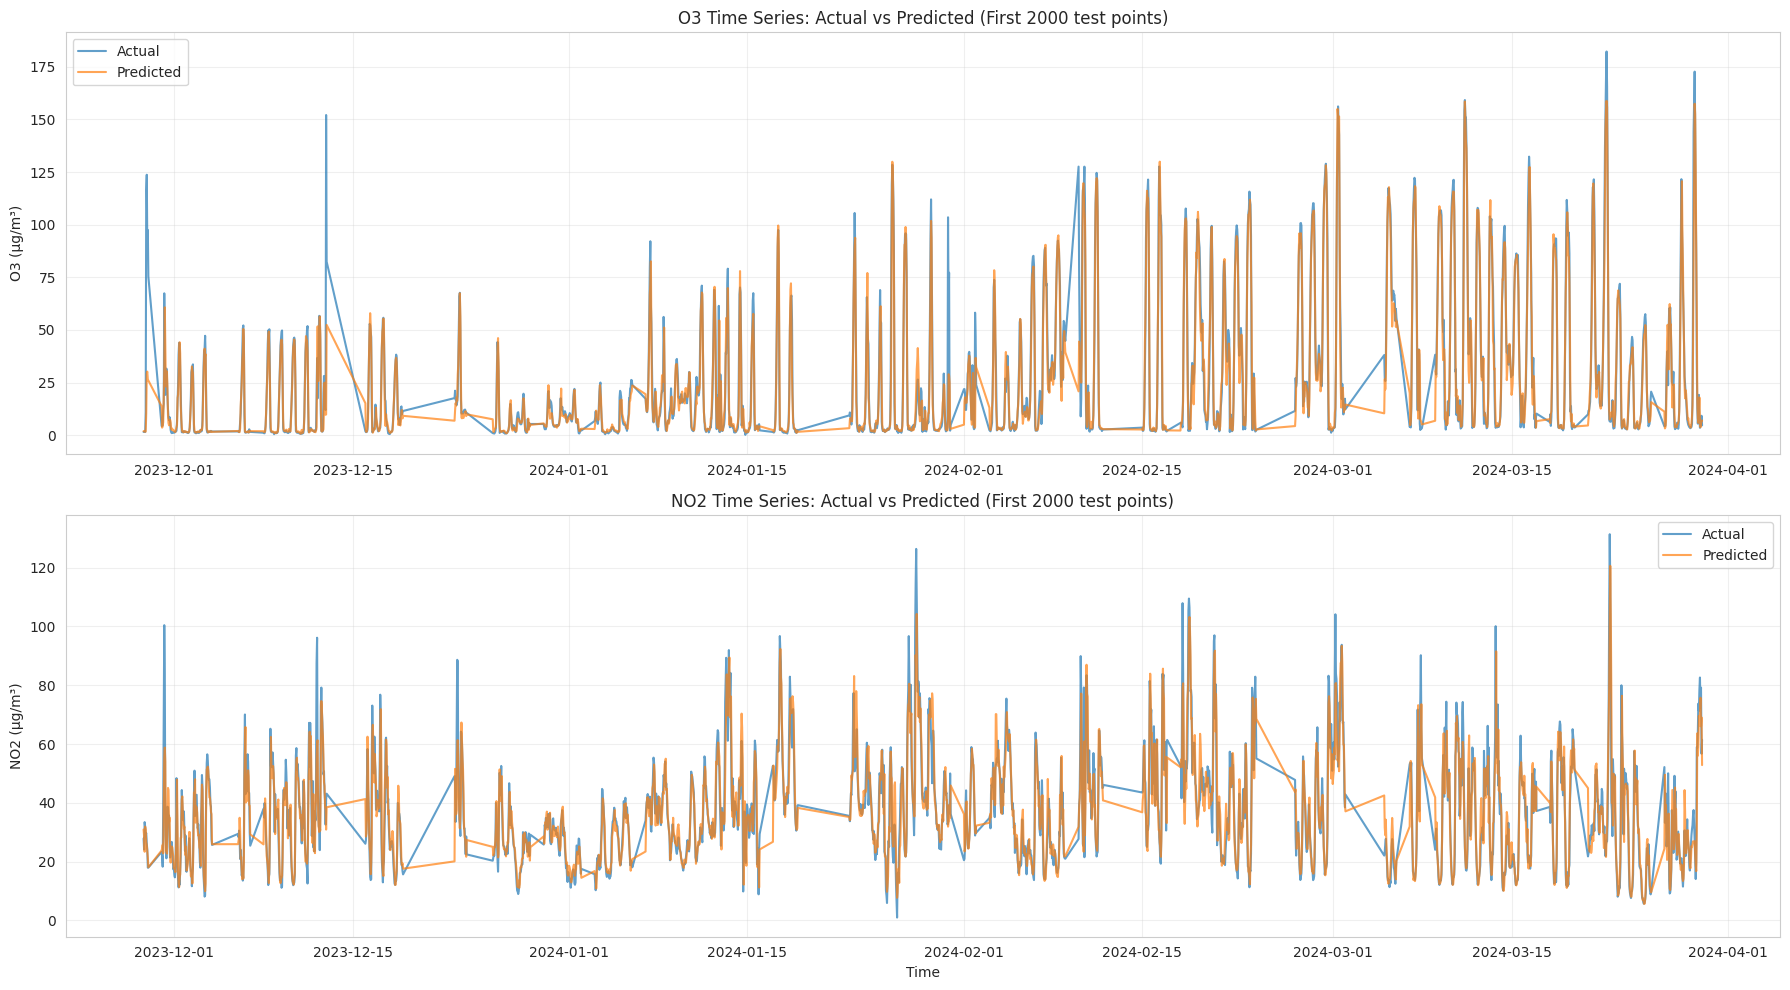

In [ ]:
# Time series plots
fig, axes = plt.subplots(2, 1, figsize=(18, 10))

# Get datetime for test set
test_datetime = df_clean.iloc[test_indices]['datetime'].values if 'datetime' in df_clean.columns else np.arange(len(y_o3_test_orig))

# Plot first 2000 points for clarity
n_plot = min(2000, len(y_o3_test_orig))

# O3 time series
axes[0].plot(test_datetime[:n_plot], y_o3_test_orig[:n_plot], label='Actual', alpha=0.7, linewidth=1.5)
axes[0].plot(test_datetime[:n_plot], y_o3_pred_test[:n_plot], label='Predicted', alpha=0.7, linewidth=1.5)
axes[0].set_ylabel('O3 (µg/m³)')
axes[0].set_title('O3 Time Series: Actual vs Predicted (First 2000 test points)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# NO2 time series
axes[1].plot(test_datetime[:n_plot], y_no2_test_orig[:n_plot], label='Actual', alpha=0.7, linewidth=1.5)
axes[1].plot(test_datetime[:n_plot], y_no2_pred_test[:n_plot], label='Predicted', alpha=0.7, linewidth=1.5)
axes[1].set_ylabel('NO2 (µg/m³)')
axes[1].set_xlabel('Time')
axes[1].set_title('NO2 Time Series: Actual vs Predicted (First 2000 test points)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/time_series.png", dpi=150, bbox_inches='tight')
plt.show()

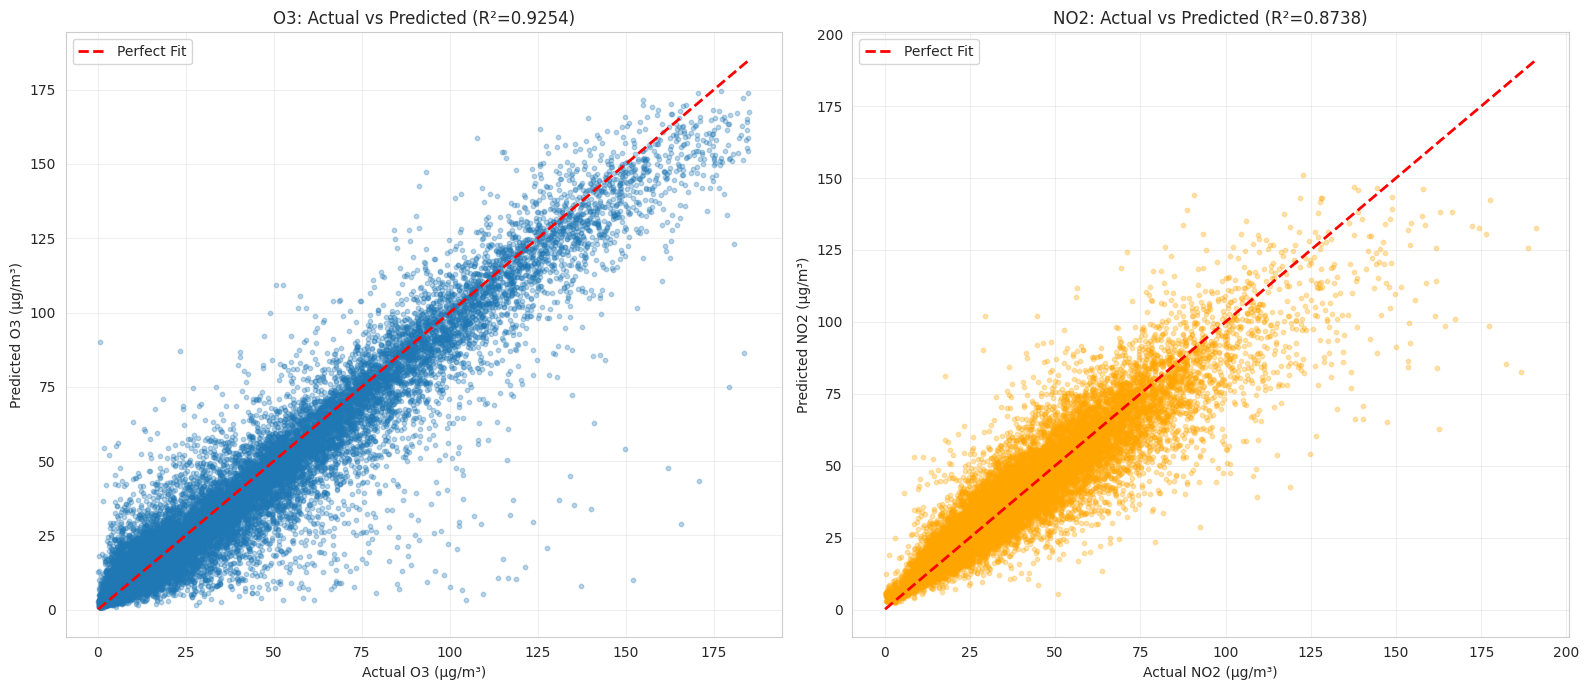

In [ ]:
# Scatter plots with 45-degree line
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# O3 scatter
axes[0].scatter(y_o3_test_orig, y_o3_pred_test, alpha=0.3, s=10)
min_val, max_val = y_o3_test_orig.min(), y_o3_test_orig.max()
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
axes[0].set_xlabel('Actual O3 (µg/m³)')
axes[0].set_ylabel('Predicted O3 (µg/m³)')
axes[0].set_title(f'O3: Actual vs Predicted (R²={r2_score(y_o3_test_orig, y_o3_pred_test):.4f})')
axes[0].legend()
axes[0].grid(alpha=0.3)

# NO2 scatter
axes[1].scatter(y_no2_test_orig, y_no2_pred_test, alpha=0.3, s=10, color='orange')
min_val, max_val = y_no2_test_orig.min(), y_no2_test_orig.max()
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
axes[1].set_xlabel('Actual NO2 (µg/m³)')
axes[1].set_ylabel('Predicted NO2 (µg/m³)')
axes[1].set_title(f'NO2: Actual vs Predicted (R²={r2_score(y_no2_test_orig, y_no2_pred_test):.4f})')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/scatter_plots.png", dpi=150, bbox_inches='tight')
plt.show()

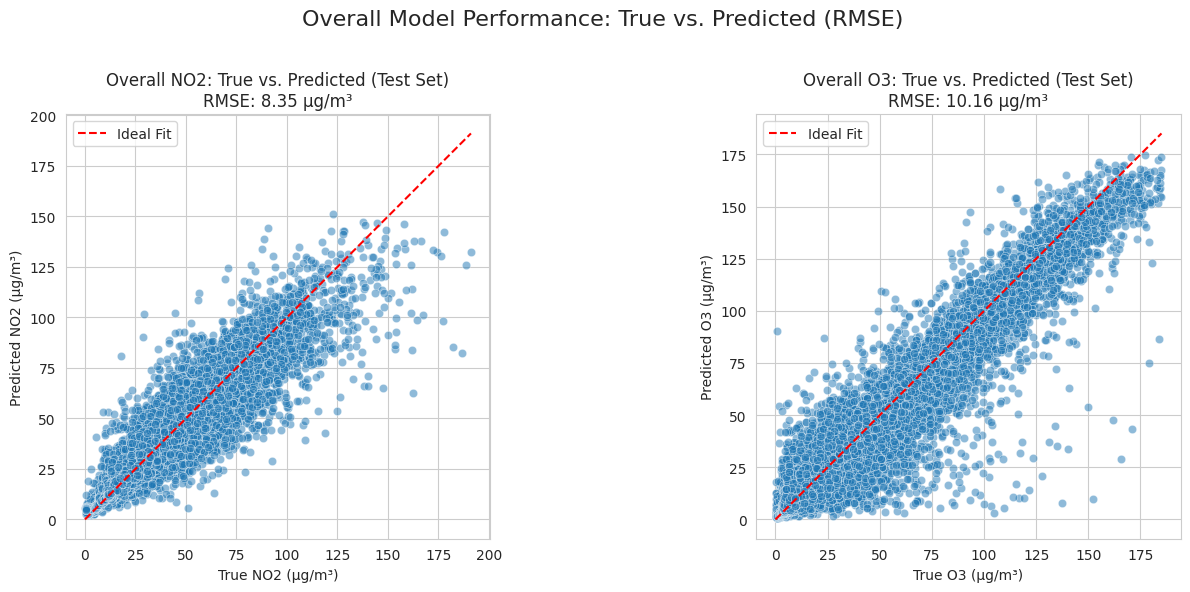

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# --- Check/Calculate Overall RMSE ---
# Assuming these variables are available from your evaluation cell:
# y_no2_test_orig, y_no2_pred_test, y_o3_test_orig, y_o3_pred_test
try:
    o3_rmse = np.sqrt(mean_squared_error(y_o3_test_orig, y_o3_pred_test))
    no2_rmse = np.sqrt(mean_squared_error(y_no2_test_orig, y_no2_pred_test))
except NameError:
    print("Please ensure y_no2_test_orig, y_no2_pred_test, etc., are defined.")

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ---- NO2 Scatter Plot ----
sns.scatterplot(x=y_no2_test_orig, y=y_no2_pred_test, ax=axes[0], alpha=0.5)
max_val_no2 = max(y_no2_test_orig.max(), y_no2_pred_test.max())
axes[0].plot([0, max_val_no2], [0, max_val_no2], 'r--', label='Ideal Fit')
axes[0].set_title(f'Overall NO2: True vs. Predicted (Test Set)\nRMSE: {no2_rmse:.2f} µg/m³')
axes[0].set_xlabel('True NO2 (µg/m³)')
axes[0].set_ylabel('Predicted NO2 (µg/m³)')
axes[0].legend()
axes[0].grid(True)
axes[0].set_aspect('equal', adjustable='box')


# ---- O3 Scatter Plot ----
sns.scatterplot(x=y_o3_test_orig, y=y_o3_pred_test, ax=axes[1], alpha=0.5)
max_val_o3 = max(y_o3_test_orig.max(), y_o3_pred_test.max())
axes[1].plot([0, max_val_o3], [0, max_val_o3], 'r--', label='Ideal Fit')
axes[1].set_title(f'Overall O3: True vs. Predicted (Test Set)\nRMSE: {o3_rmse:.2f} µg/m³')
axes[1].set_xlabel('True O3 (µg/m³)')
axes[1].set_ylabel('Predicted O3 (µg/m³)')
axes[1].legend()
axes[1].grid(True)
axes[1].set_aspect('equal', adjustable='box')

plt.suptitle('Overall Model Performance: True vs. Predicted (RMSE)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('overall_rmse_scatterplot.png')
plt.show()

Plotting data for site: 6
Date range: 2023-11-28 14:00:00 to 2024-06-30 00:00:00
Total data points: 2946

PART 1: Ground Truth vs. Predicted Plots

--- O3 (Ozone) Forecasts ---

Generating 1 Day (Hourly) plot...
✓ Saved: 6_O3_1_day_hourly_ground_vs_pred.png


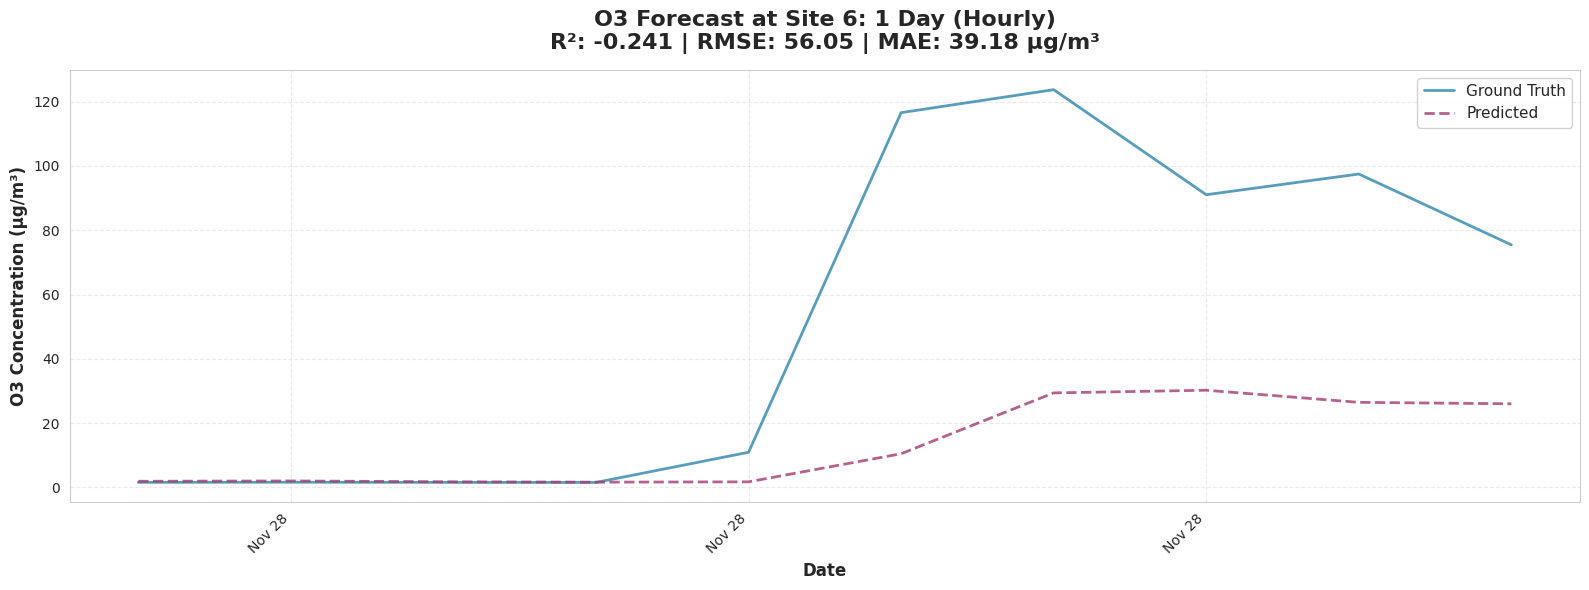


Generating 1 Week (7 Days) plot...
✓ Saved: 6_O3_1_week_7_days_ground_vs_pred.png


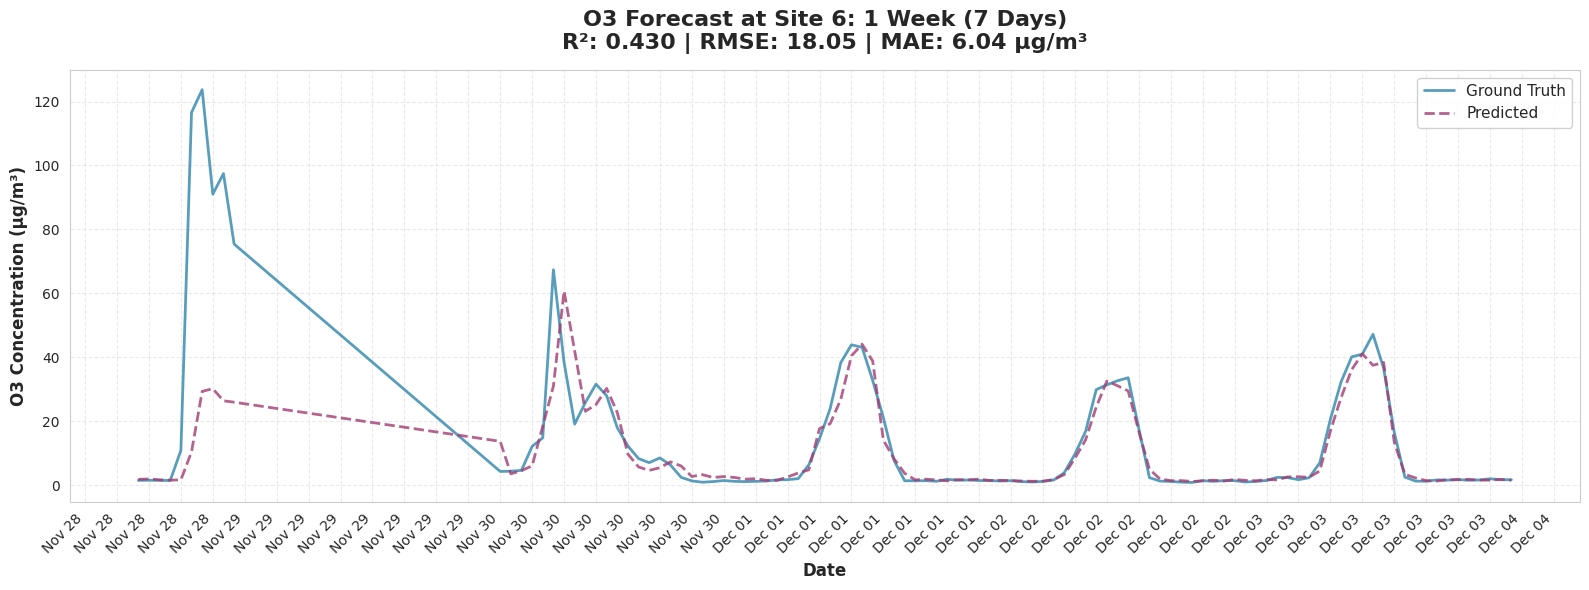


Generating 1 Month (30 Days) plot...
✓ Saved: 6_O3_1_month_30_days_ground_vs_pred.png


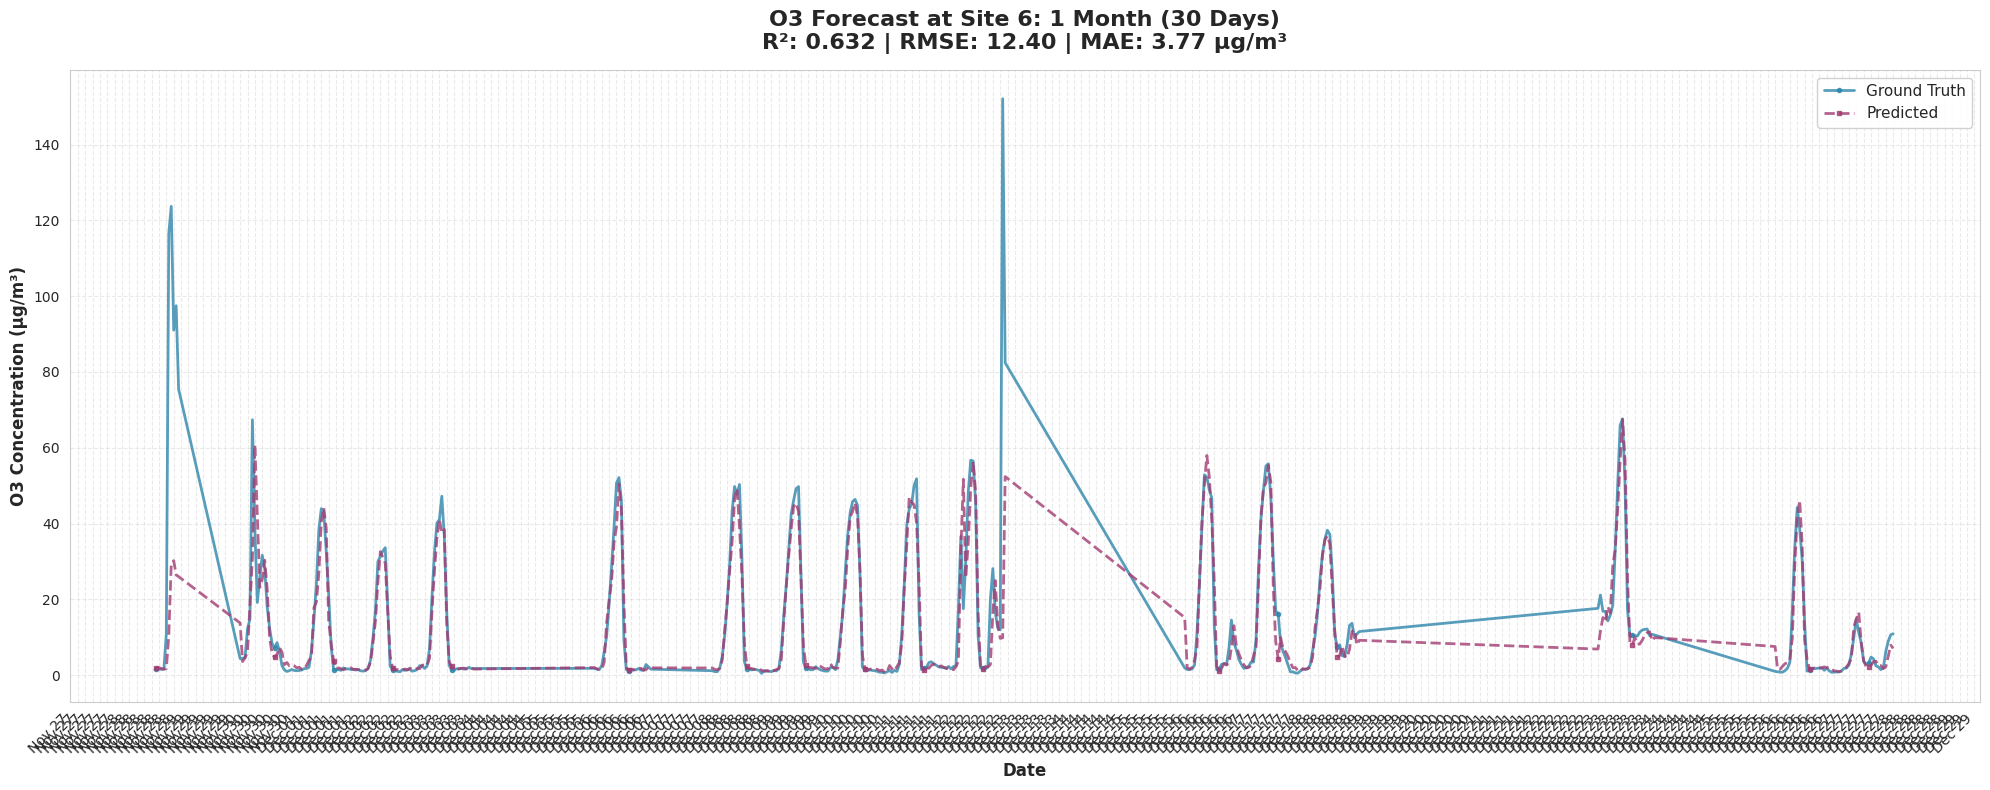


Generating 1 Year (Full Test Set) plot...
✓ Saved: 6_O3_1_year_full_test_set_ground_vs_pred.png


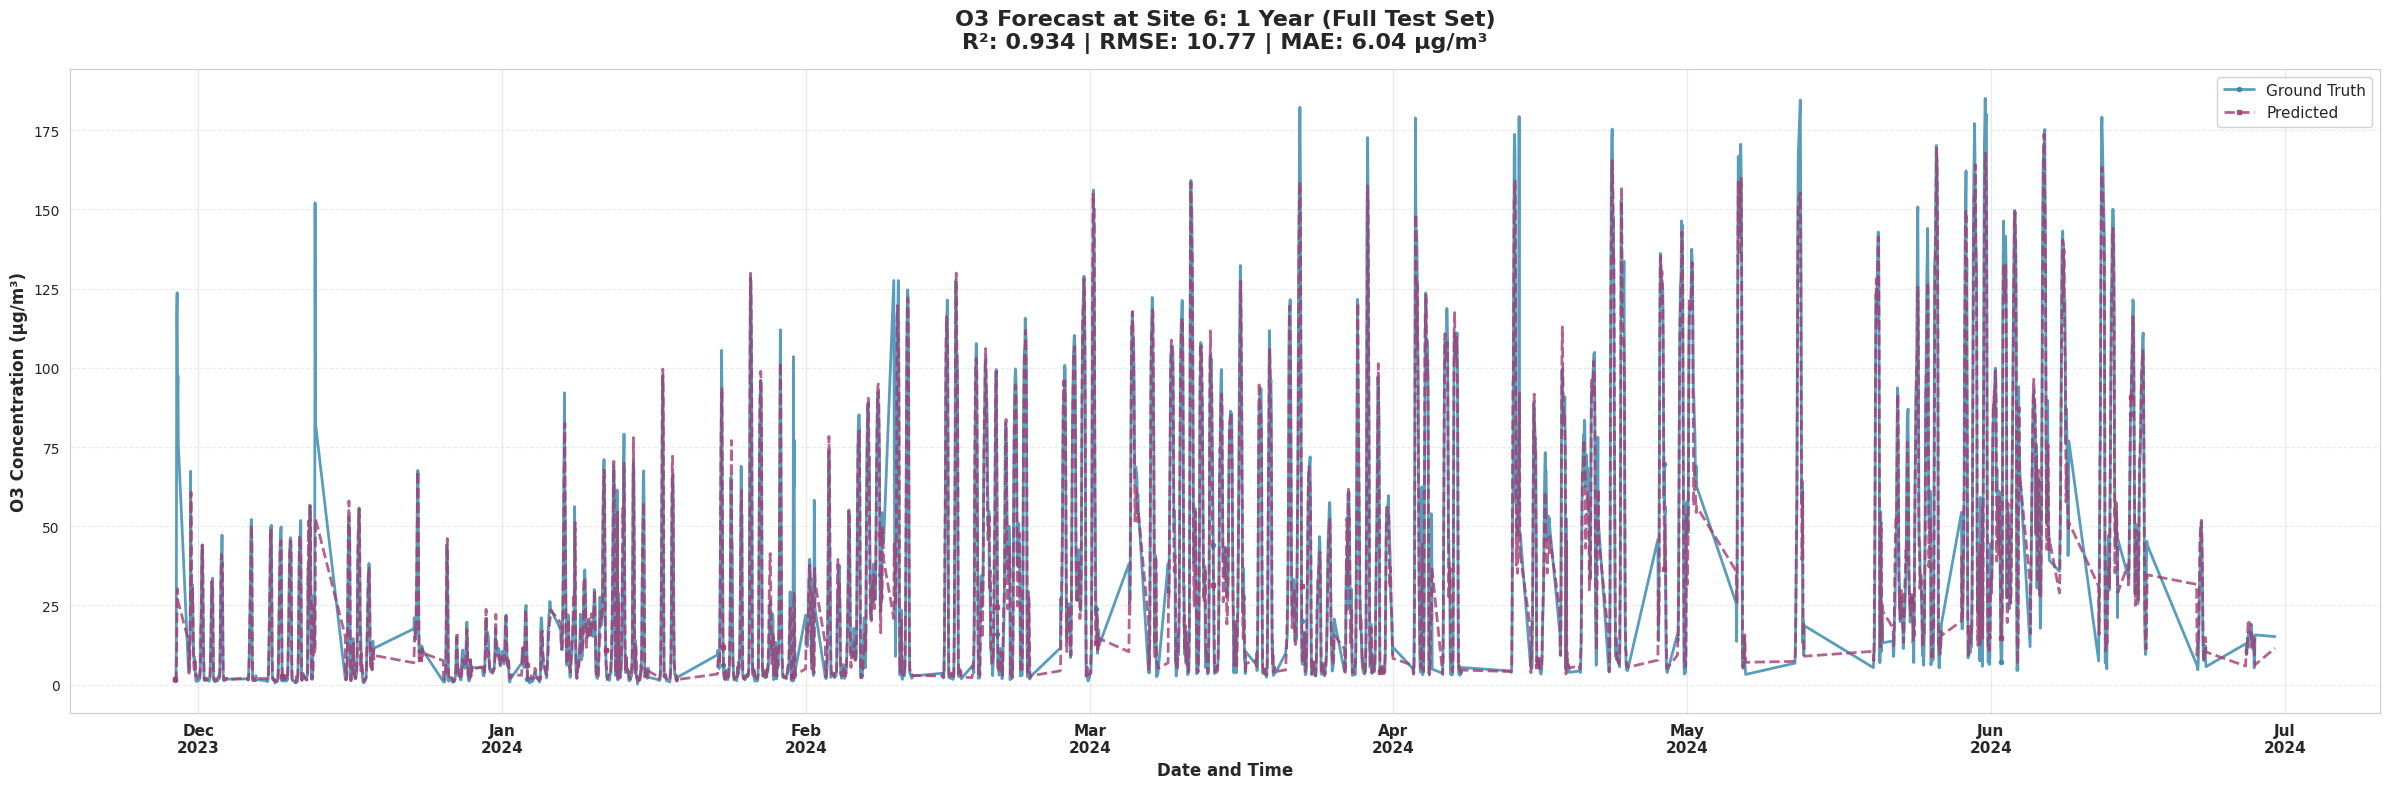


--- NO2 (Nitrogen Dioxide) Forecasts ---

Generating 1 Day (Hourly) plot...
✓ Saved: 6_NO2_1_day_hourly_ground_vs_pred.png


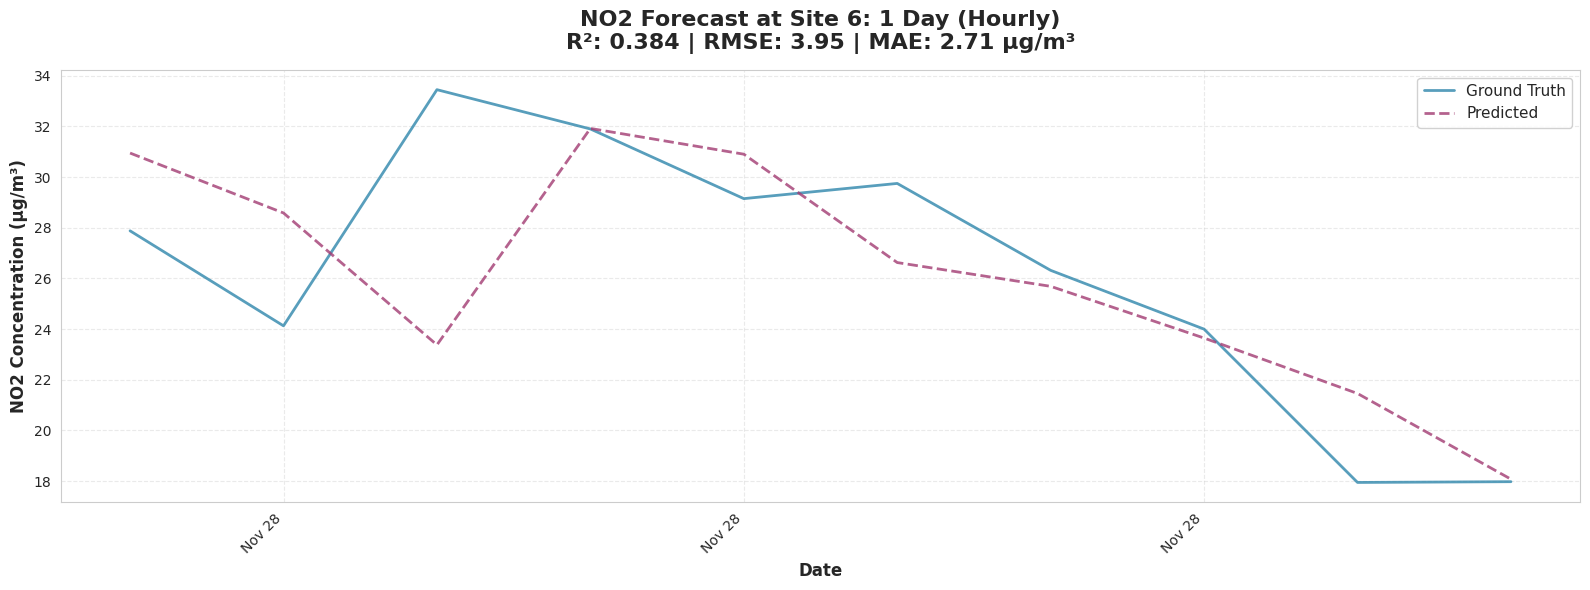


Generating 1 Week (7 Days) plot...
✓ Saved: 6_NO2_1_week_7_days_ground_vs_pred.png


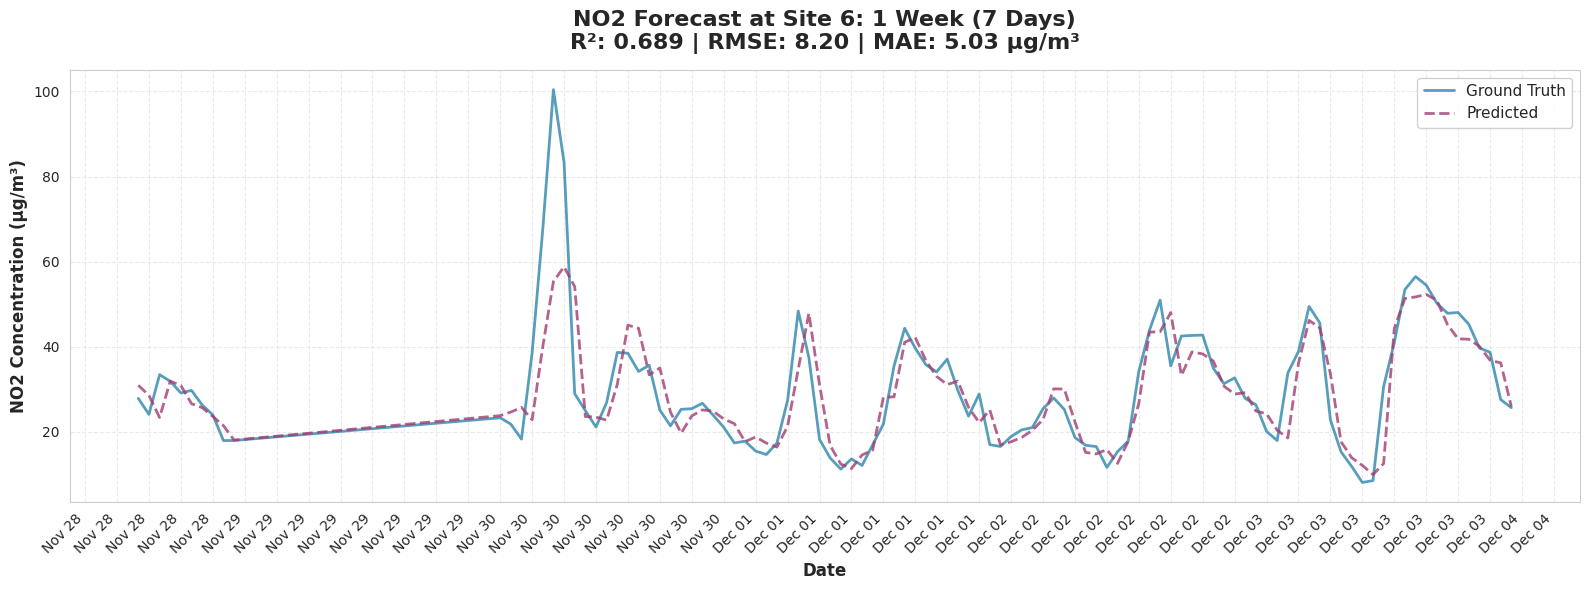


Generating 1 Month (30 Days) plot...
✓ Saved: 6_NO2_1_month_30_days_ground_vs_pred.png


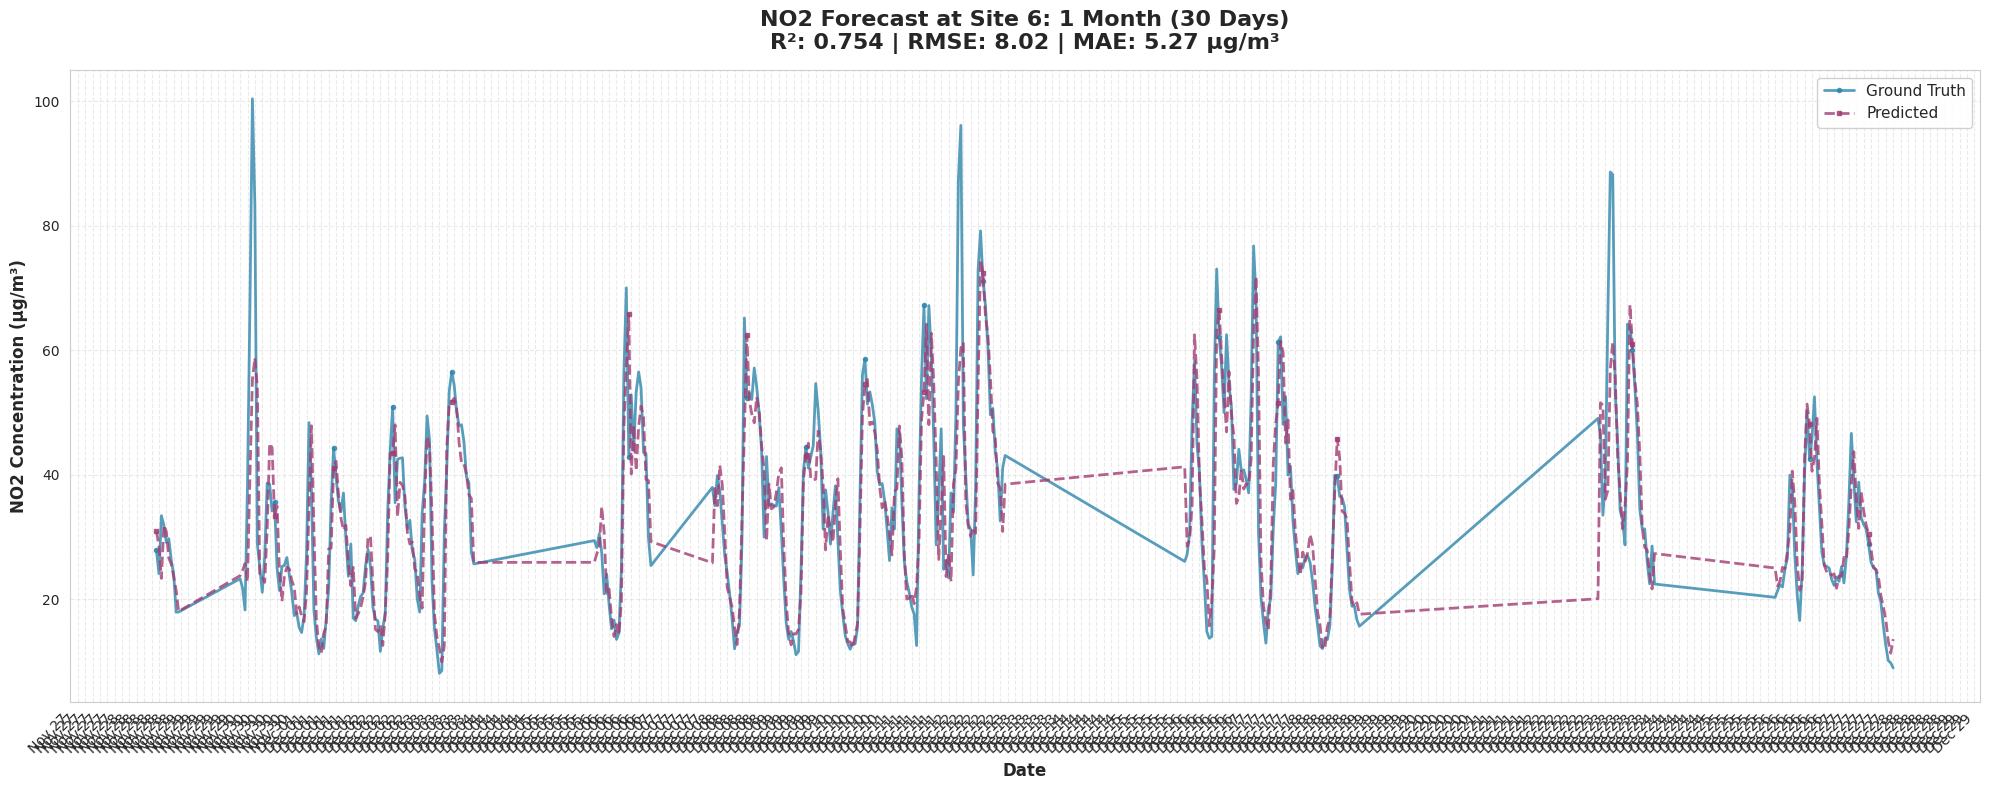


Generating 1 Year (Full Test Set) plot...
✓ Saved: 6_NO2_1_year_full_test_set_ground_vs_pred.png


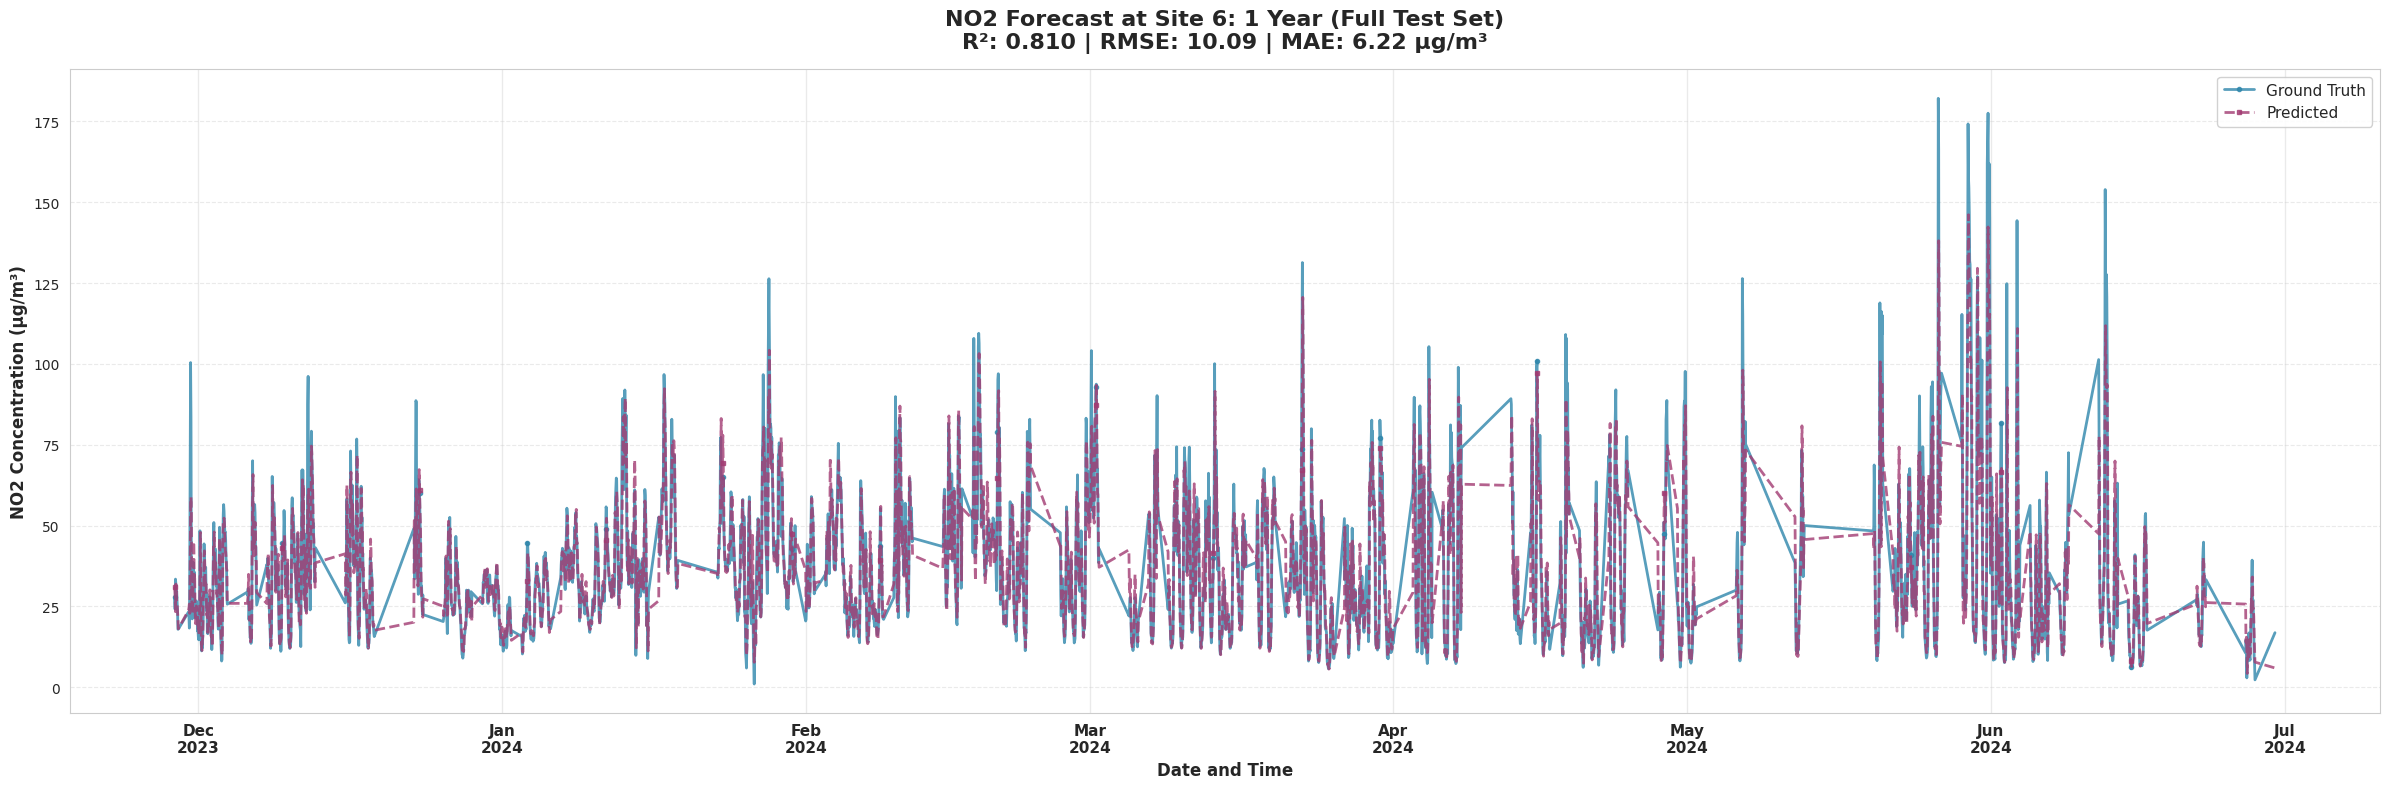


PART 2: Error Time Series Plots

--- O3 (Ozone) Errors ---

Generating 1 Day (Hourly) error plot...
✓ Saved: 6_O3_1_day_hourly_error_timeseries.png


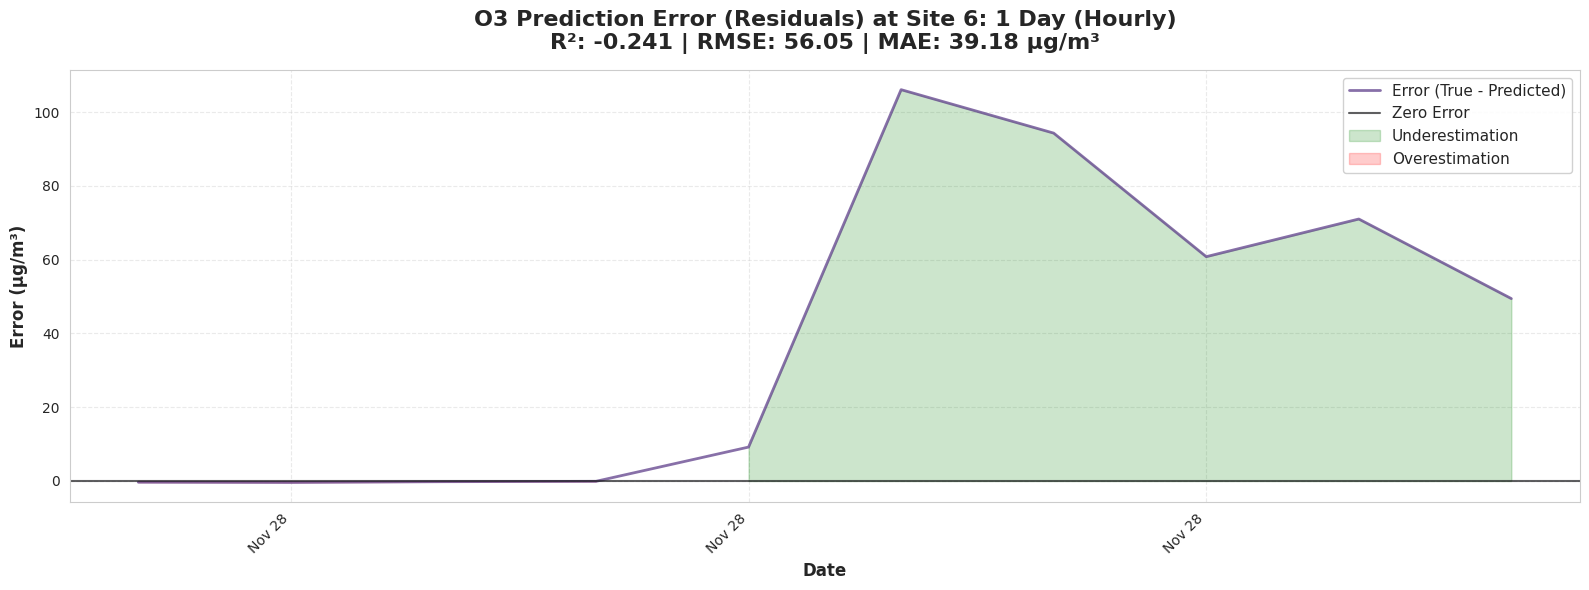


Generating 1 Week (7 Days) error plot...
✓ Saved: 6_O3_1_week_7_days_error_timeseries.png


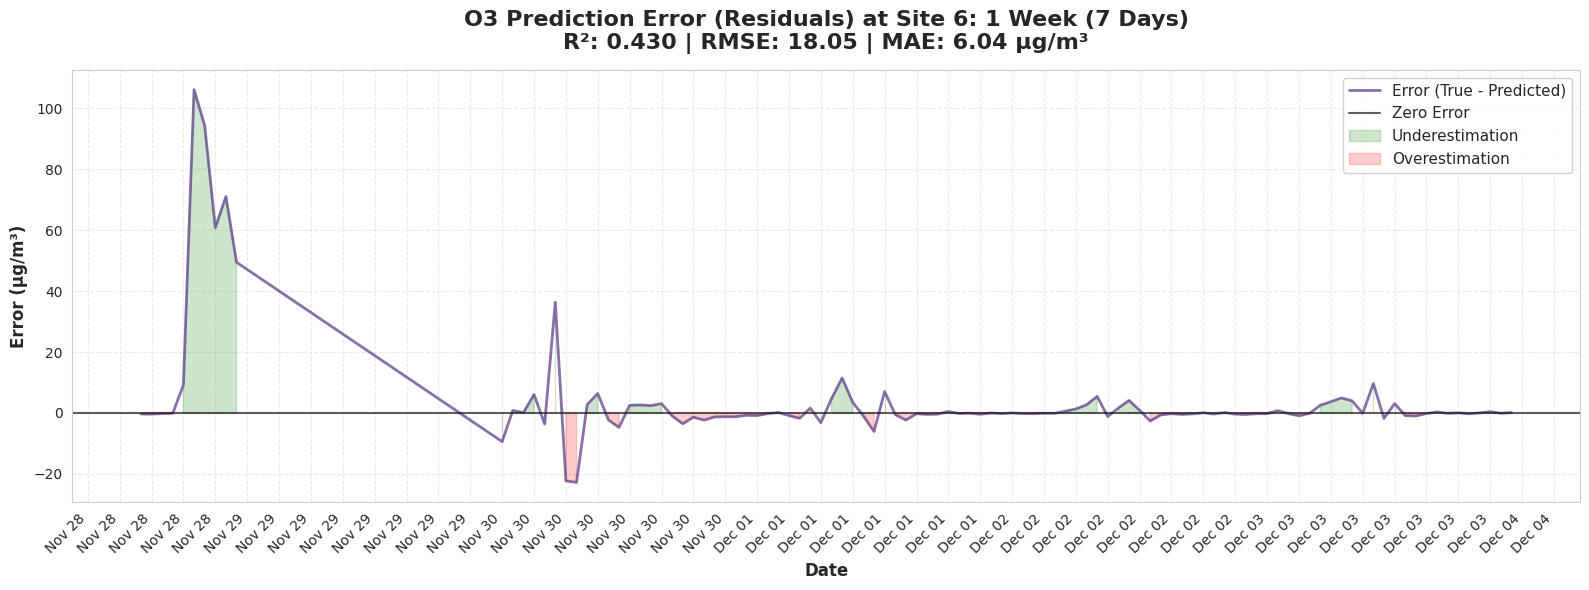


Generating 1 Month (30 Days) error plot...
✓ Saved: 6_O3_1_month_30_days_error_timeseries.png


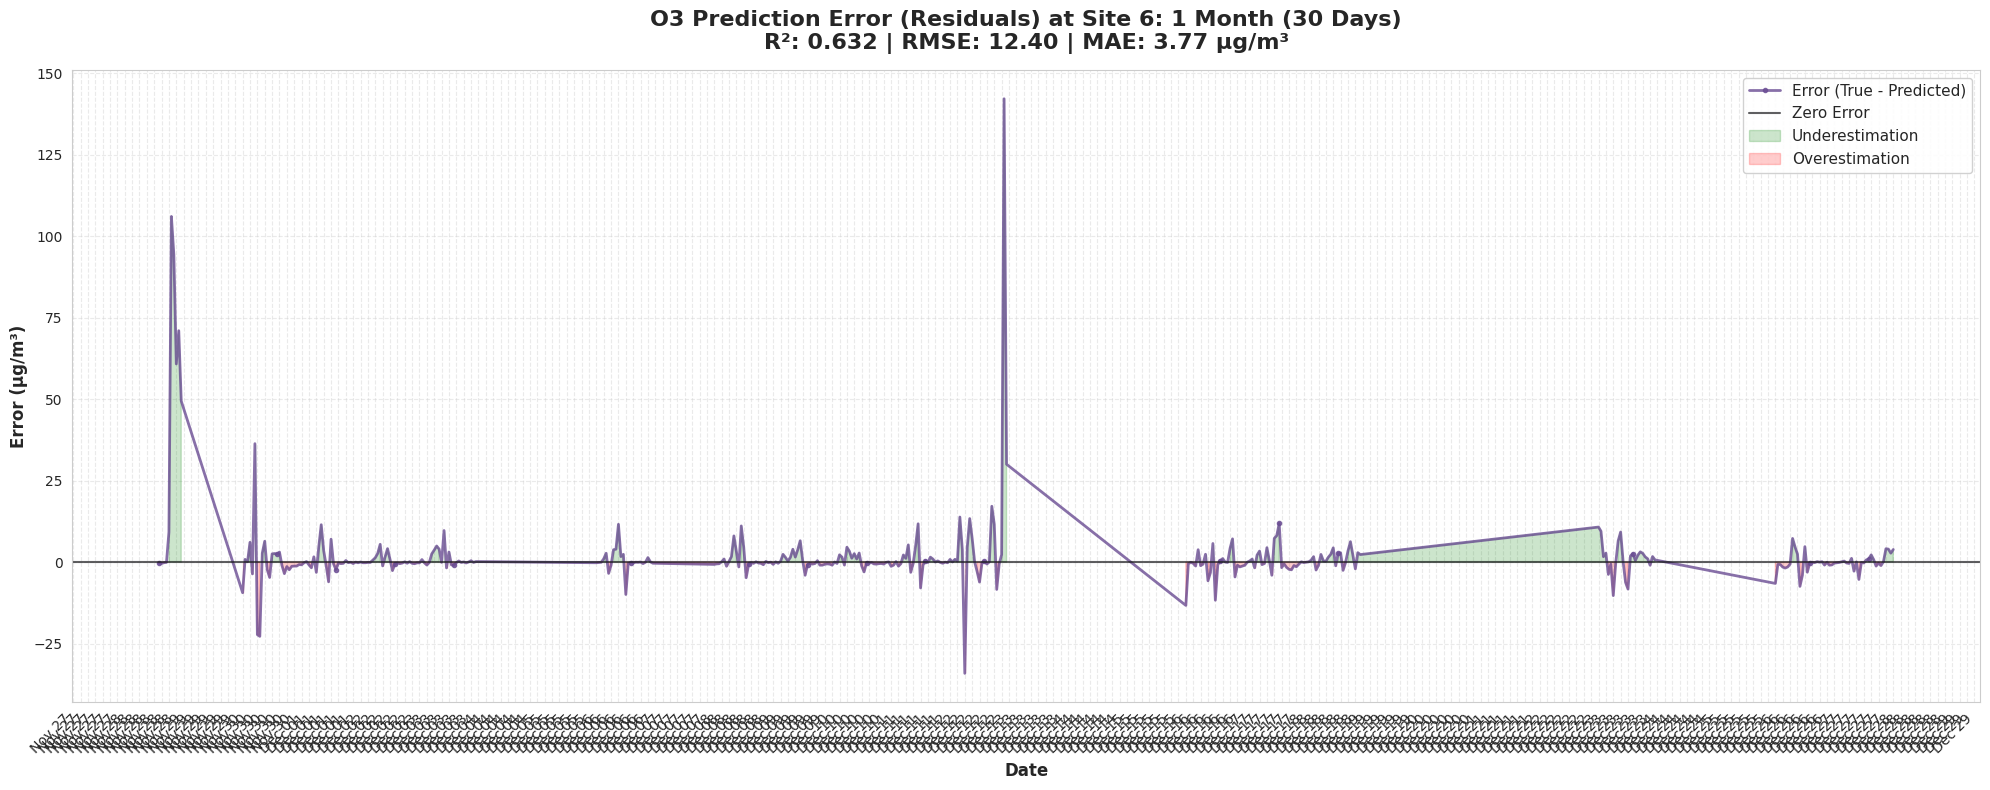


Generating 1 Year (Full Test Set) error plot...
✓ Saved: 6_O3_1_year_full_test_set_error_timeseries.png


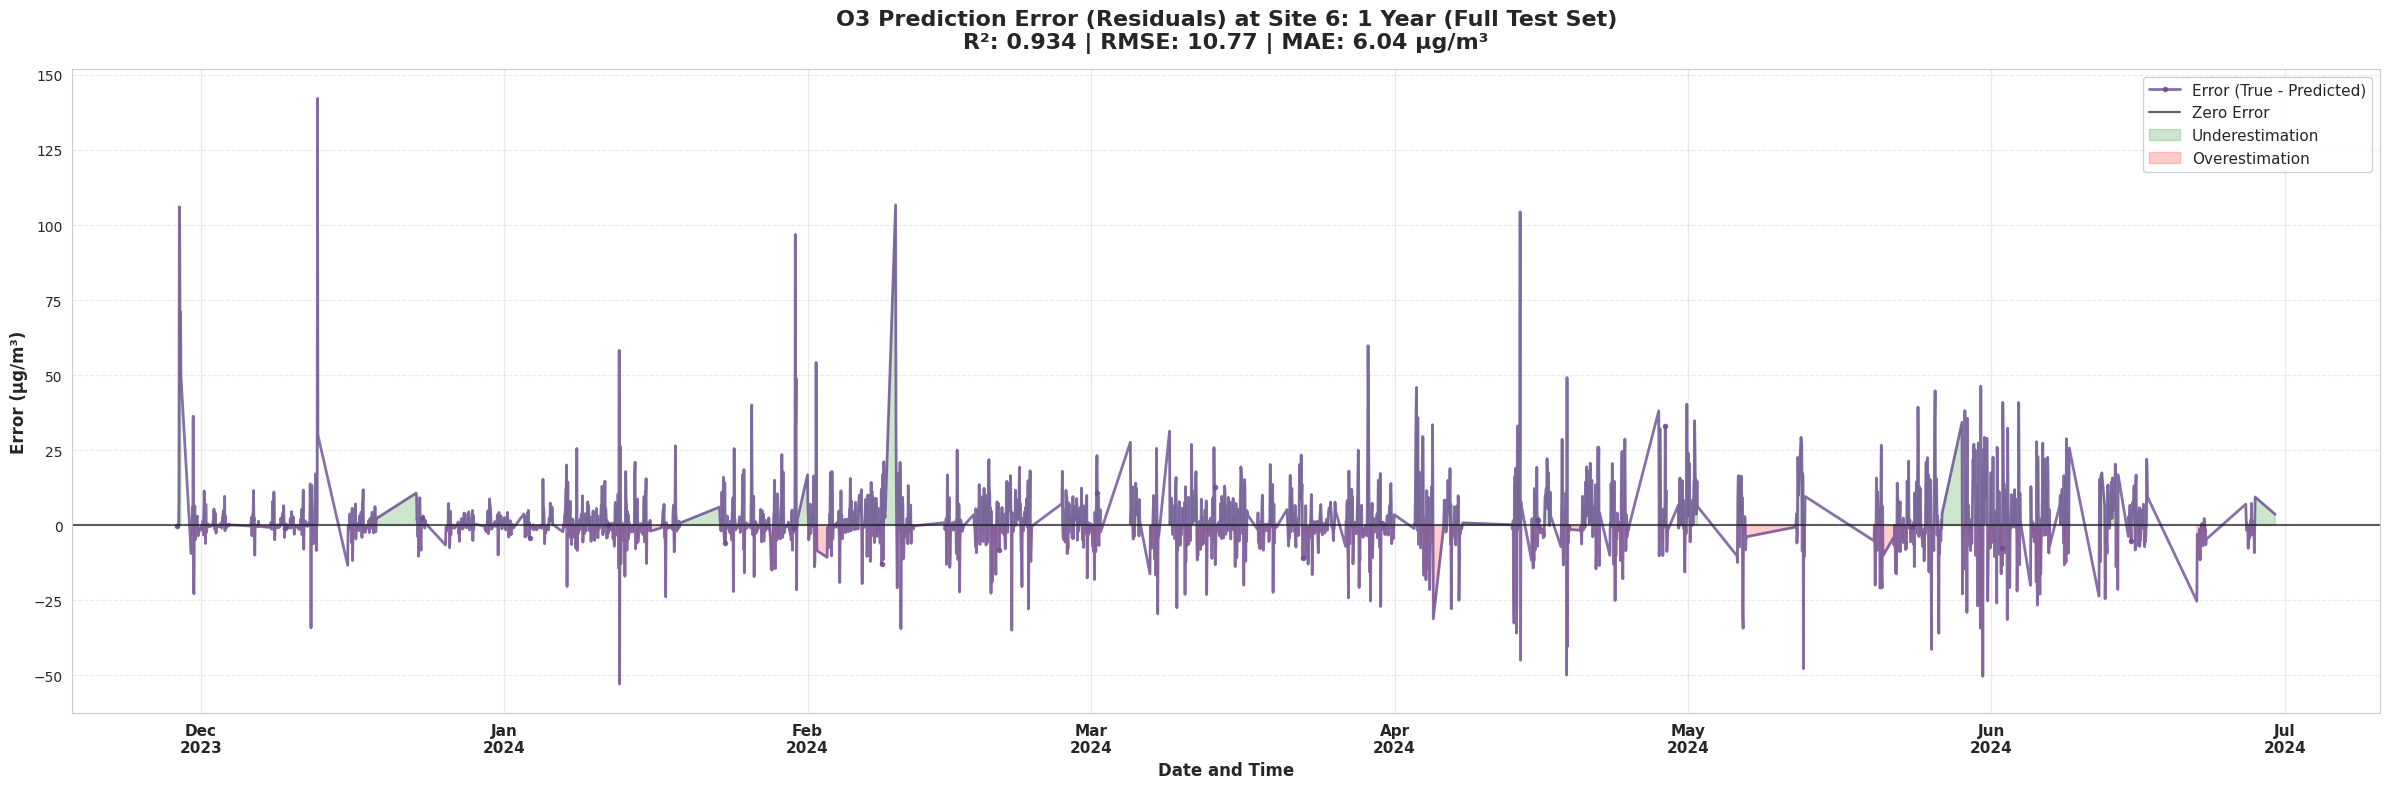


--- NO2 (Nitrogen Dioxide) Errors ---

Generating 1 Day (Hourly) error plot...
✓ Saved: 6_NO2_1_day_hourly_error_timeseries.png


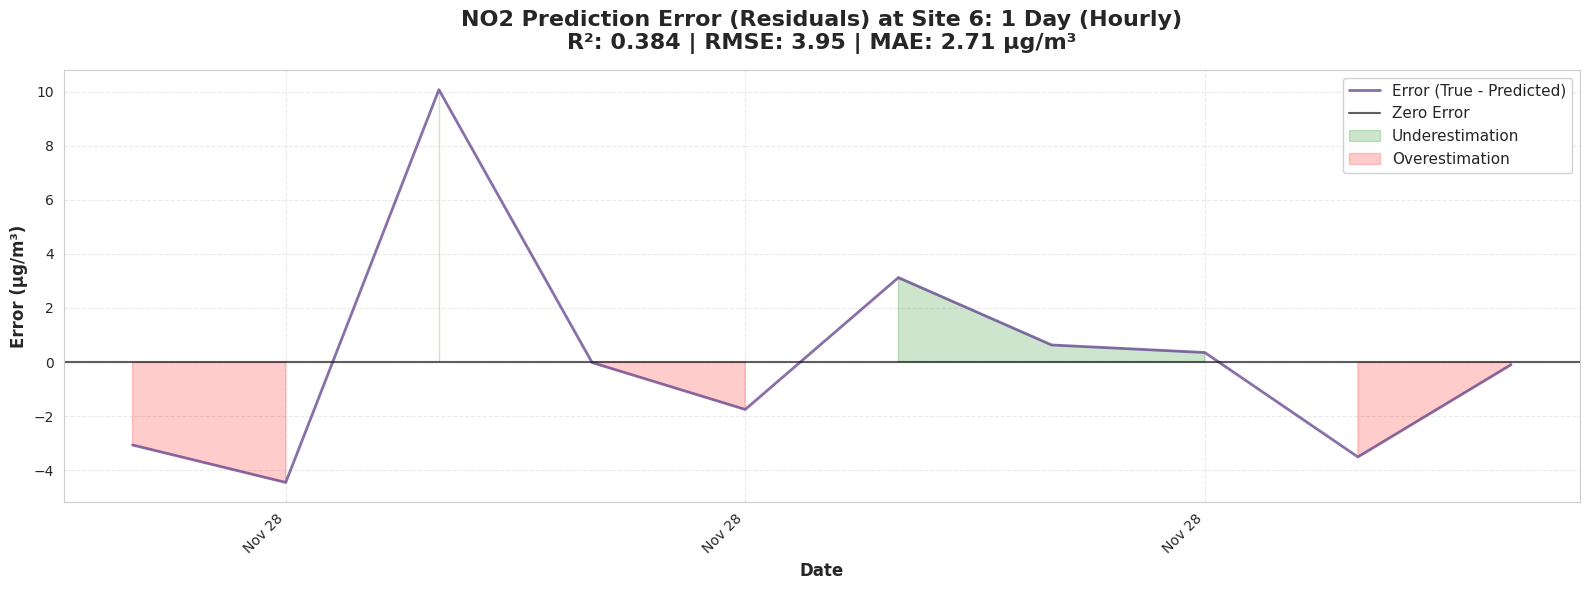


Generating 1 Week (7 Days) error plot...
✓ Saved: 6_NO2_1_week_7_days_error_timeseries.png


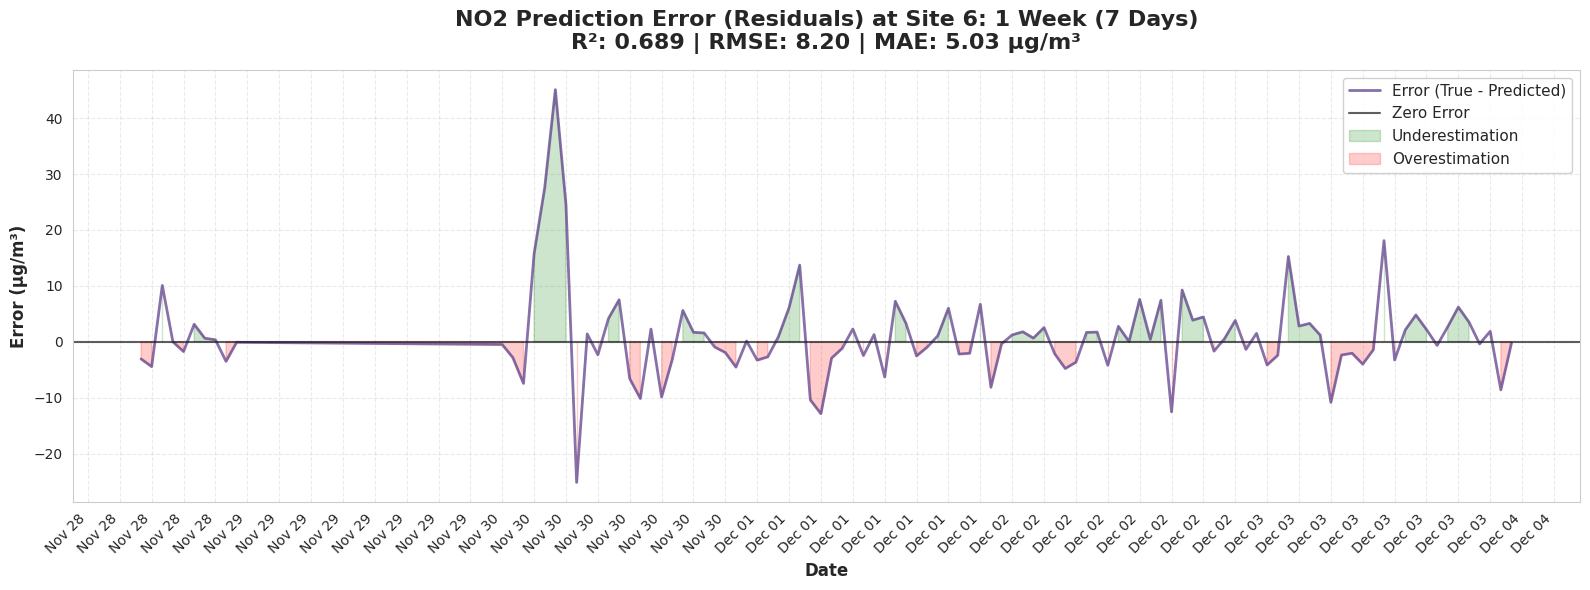


Generating 1 Month (30 Days) error plot...
✓ Saved: 6_NO2_1_month_30_days_error_timeseries.png


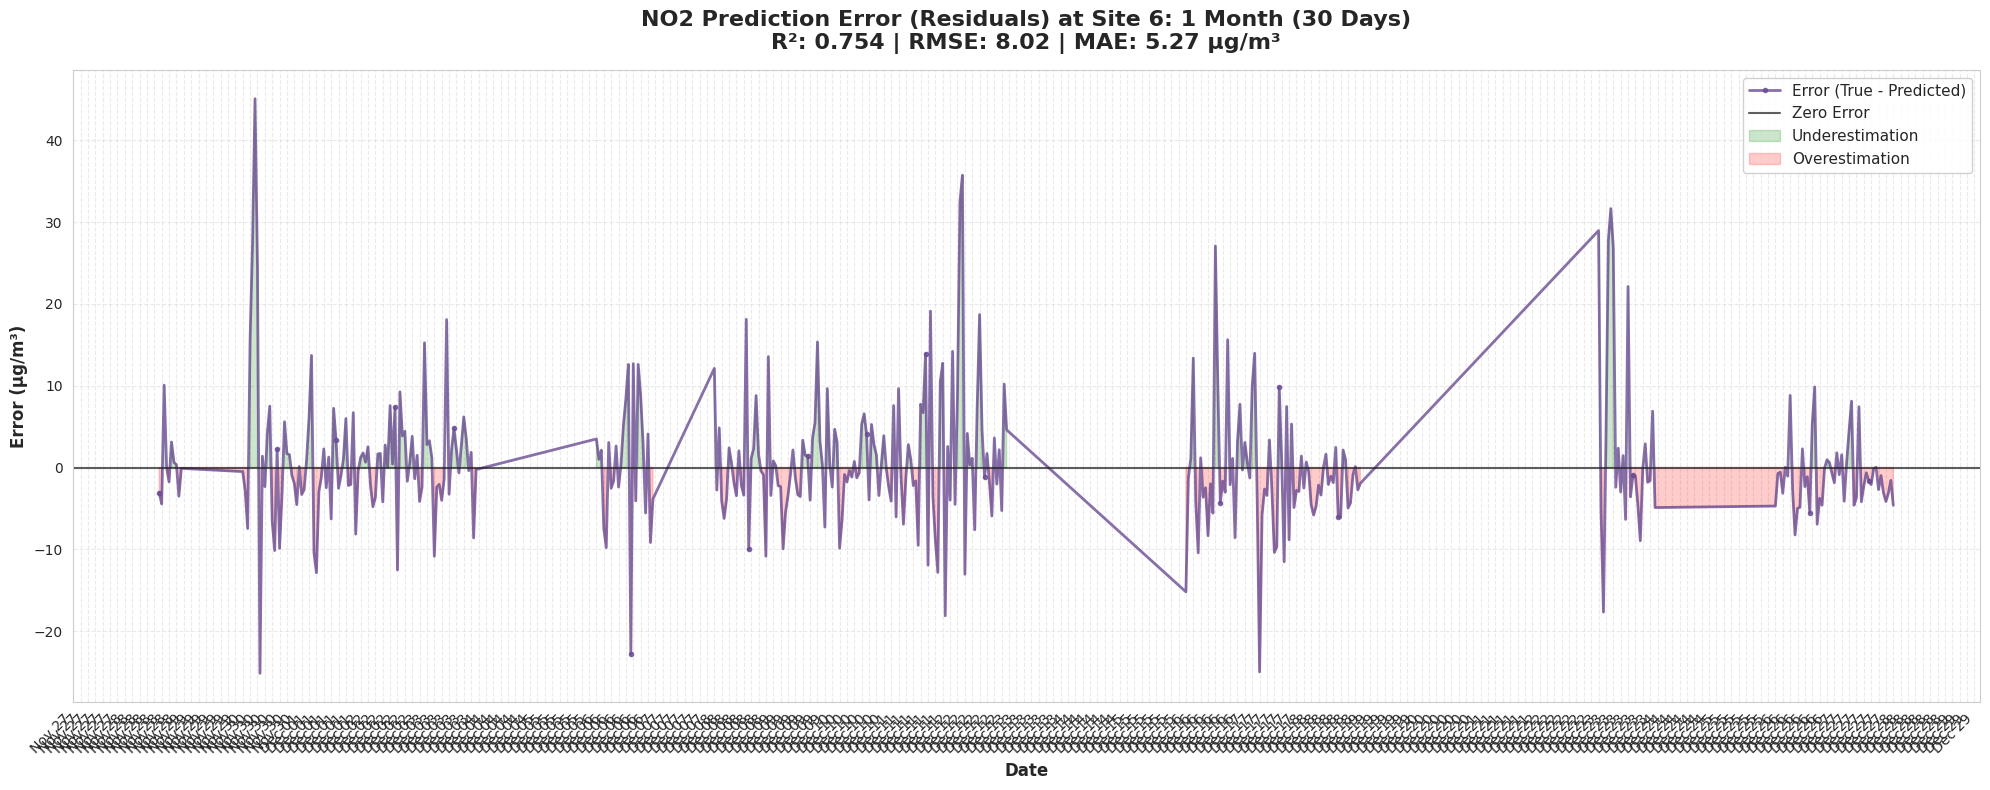


Generating 1 Year (Full Test Set) error plot...
✓ Saved: 6_NO2_1_year_full_test_set_error_timeseries.png


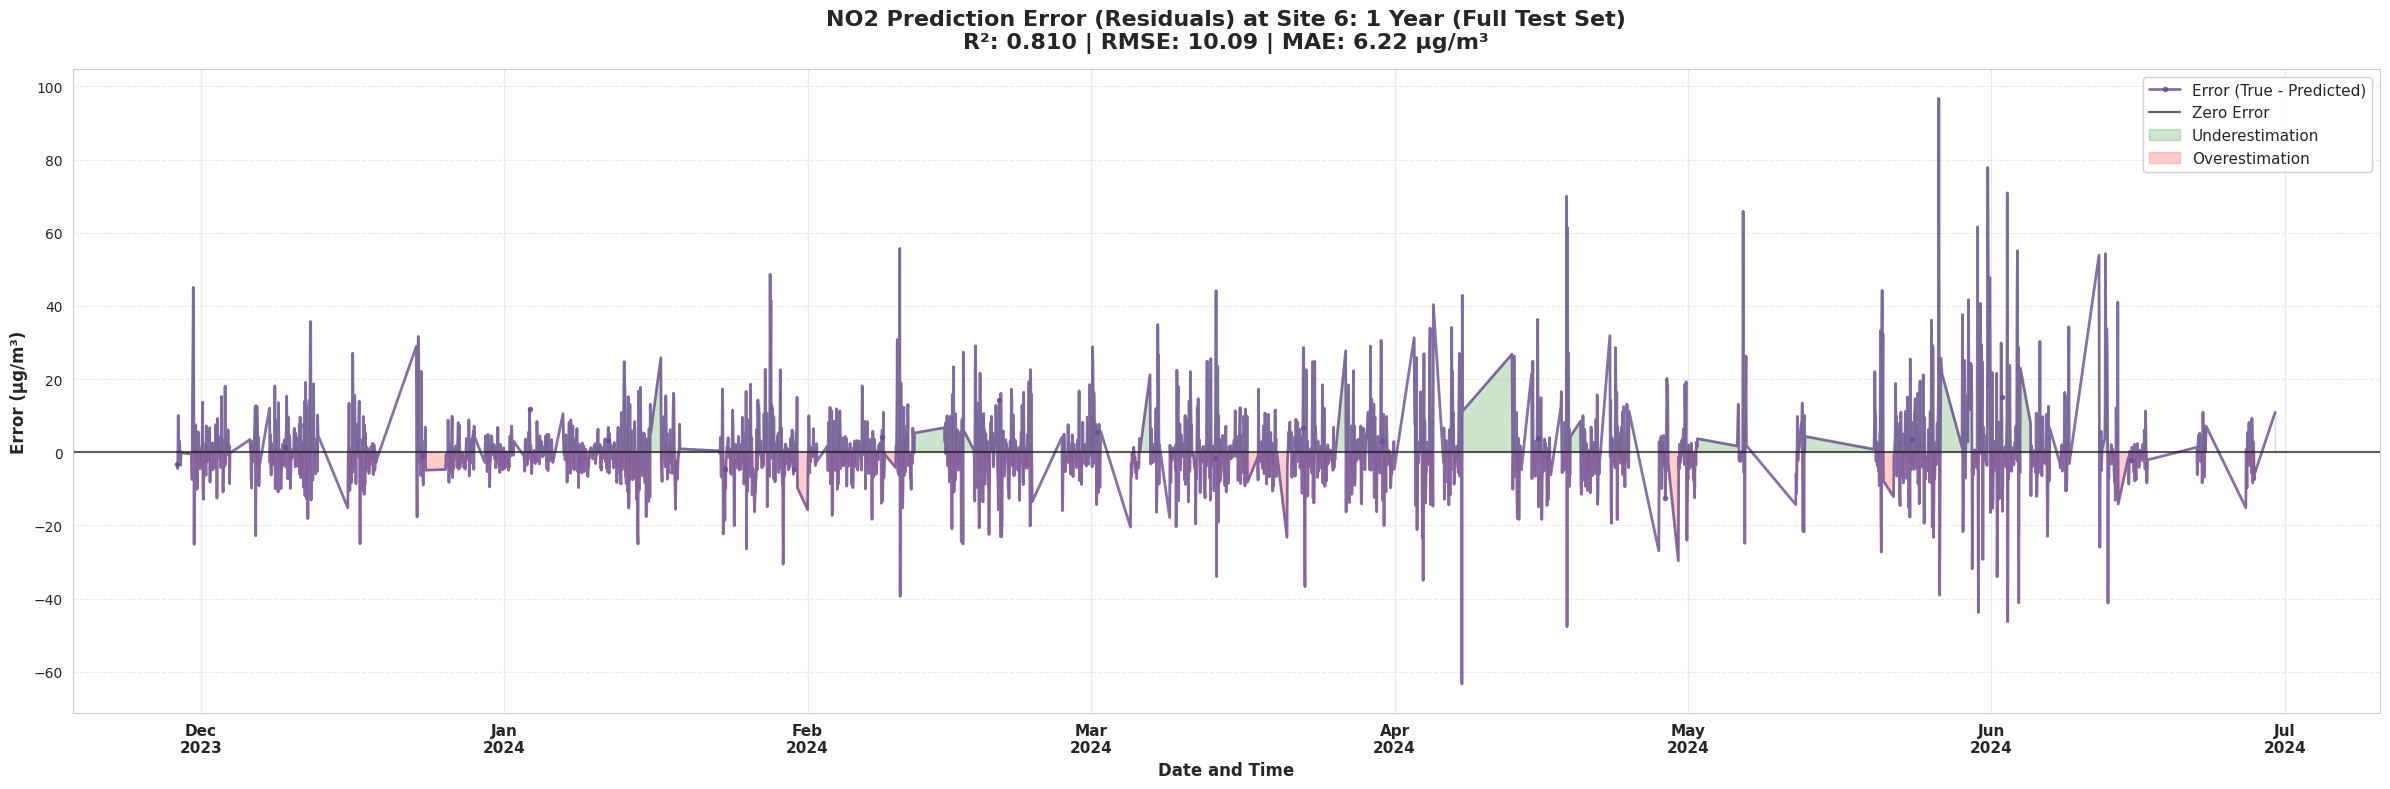


✓ All plots generated successfully!


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.dates as mdates

# =======================================================================
# 1. Data Preparation
# =======================================================================

# Create test_df from the test indices with datetime column
test_df = df_clean.iloc[test_indices].copy()

# Add predictions to test results
test_results = test_df.copy()
test_results['NO2_True'] = y_no2_test_orig
test_results['NO2_Pred'] = y_no2_pred_test
test_results['O3_True'] = y_o3_test_orig
test_results['O3_Pred'] = y_o3_pred_test

# Filter for the first site and set datetime as index
SITE_TO_PLOT = test_results['site'].unique()[0]
site_1_data = test_results[test_results['site'] == SITE_TO_PLOT].set_index('datetime').sort_index()

if site_1_data.empty:
    raise ValueError(f"No data found for site {SITE_TO_PLOT}. Please check your test_df contents.")

print(f"Plotting data for site: {SITE_TO_PLOT}")
print(f"Date range: {site_1_data.index.min()} to {site_1_data.index.max()}")
print(f"Total data points: {len(site_1_data)}")

# =======================================================================
# 2. Define Time Intervals
# =======================================================================

T0 = site_1_data.index.min().normalize()
T_END = site_1_data.index.max()

TIME_PERIODS = [
    ('1 Day (Hourly)', T0 + pd.Timedelta(days=1)),
    ('1 Week (7 Days)', T0 + pd.Timedelta(days=7)),
    ('1 Month (30 Days)', T0 + pd.Timedelta(days=30)),
    ('1 Year (Full Test Set)', T_END)
]

# =======================================================================
# 3. Plotting Function (IMPROVED)
# =======================================================================

def plot_time_series(df, pollutant, period_name, end_date, plot_type='ground_vs_pred'):
    """Generates a time series plot for a specific pollutant, period, and plot type."""

    plot_df = df[df.index <= end_date]
    if plot_df.empty:
        print(f"⚠ Skipping plot: No data found for {pollutant} during {period_name}.")
        return

    # Calculate metrics for the period
    true_values = plot_df[f'{pollutant}_True']
    pred_values = plot_df[f'{pollutant}_Pred']

    # Remove any NaN values
    mask = ~(np.isnan(true_values) | np.isnan(pred_values))
    true_values_clean = true_values[mask]
    pred_values_clean = pred_values[mask]

    if len(true_values_clean) == 0:
        print(f"⚠ Skipping plot: No valid data for {pollutant} during {period_name}.")
        return

    r2 = r2_score(true_values_clean, pred_values_clean)
    rmse = np.sqrt(mean_squared_error(true_values_clean, pred_values_clean))
    mae = np.mean(np.abs(true_values_clean - pred_values_clean))

    # Adjust figure size based on period for better timestamp visibility
    if 'Month' in period_name:
        figsize = (20, 8)  # Wider and taller for 1 month
    elif 'Year' in period_name:
        figsize = (24, 8)  # Extra wide for full year
    else:
        figsize = (16, 6)  # Standard for day and week

    fig, ax = plt.subplots(figsize=figsize)

    # Plotting Logic
    if plot_type == 'ground_vs_pred':
        # Add markers for better visibility on longer time periods
        marker_style = 'o' if 'Month' in period_name or 'Year' in period_name else None
        marker_every = 24 if 'Month' in period_name else 168 if 'Year' in period_name else None
        marker_size = 3 if marker_style else 0

        ax.plot(plot_df.index, true_values, label='Ground Truth',
                color='#2E86AB', linewidth=2, alpha=0.8,
                marker=marker_style, markersize=marker_size, markevery=marker_every)
        ax.plot(plot_df.index, pred_values, label='Predicted',
                color='#A23B72', linestyle='--', linewidth=2, alpha=0.8,
                marker='s' if marker_style else None, markersize=marker_size, markevery=marker_every)
        title_prefix = f'{pollutant} Forecast'
        file_suffix = 'ground_vs_pred'
        y_label = f'{pollutant} Concentration (μg/m³)'

    elif plot_type == 'error':
        error_values = true_values - pred_values
        marker_style = 'o' if 'Month' in period_name or 'Year' in period_name else None
        marker_every = 24 if 'Month' in period_name else 168 if 'Year' in period_name else None
        marker_size = 3 if marker_style else 0

        ax.plot(plot_df.index, error_values, label='Error (True - Predicted)',
                color='#6A4C93', linewidth=2, alpha=0.8,
                marker=marker_style, markersize=marker_size, markevery=marker_every)
        ax.axhline(0, color='#1B1B1E', linestyle='-', linewidth=1.5,
                   alpha=0.7, label='Zero Error')
        ax.fill_between(plot_df.index, 0, error_values,
                        where=(error_values > 0), alpha=0.2, color='green',
                        label='Underestimation')
        ax.fill_between(plot_df.index, 0, error_values,
                        where=(error_values < 0), alpha=0.2, color='red',
                        label='Overestimation')
        title_prefix = f'{pollutant} Prediction Error (Residuals)'
        file_suffix = 'error_timeseries'
        y_label = f'Error (μg/m³)'

    # Title with metrics
    metrics_text = f'R²: {r2:.3f} | RMSE: {rmse:.2f} | MAE: {mae:.2f} μg/m³'
    ax.set_title(f'{title_prefix} at Site {SITE_TO_PLOT}: {period_name}\n{metrics_text}',
                 fontsize=16, fontweight='bold', pad=15)
    ax.set_xlabel('Date and Time', fontsize=12, fontweight='bold')
    ax.set_ylabel(y_label, fontsize=12, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.4, linewidth=0.8)
    ax.legend(loc='best', fontsize=11, framealpha=0.9)

    # IMPROVED X-axis formatting with better timestamp visibility
    if 'Day' in period_name:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
        ax.set_xlabel('Date', fontsize=12, fontweight='bold')
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=10)

    elif 'Week' in period_name:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=10)

    elif 'Month' in period_name:
        # Show only dates (day numbers) every 2 days for clean spacing
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))  # Just day number
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))  # Every 2 days

        # Add month-year label to x-axis
        month_year = plot_df.index[0].strftime('%B %Y')
        ax.set_xlabel(f'Day of {month_year}', fontsize=13, fontweight='bold')

        # Clean horizontal labels
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='center',
                 fontsize=11, fontweight='normal')

    else:  # Full year
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())

        # Add grid lines
        ax.xaxis.grid(True, which='major', linestyle='-', alpha=0.4, linewidth=1)
        ax.xaxis.grid(True, which='minor', linestyle=':', alpha=0.2, linewidth=0.5)

        plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='center', fontsize=11, fontweight='bold')

    plt.tight_layout()

    # Save figure
    filename = f'{SITE_TO_PLOT}_{pollutant}_{period_name.replace(" ", "_").replace("(", "").replace(")", "").lower()}_{file_suffix}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f'✓ Saved: {filename}')
    plt.show()
    plt.close()

# =======================================================================
# 4. Generate All Plots
# =======================================================================

print("\n" + "="*70)
print("PART 1: Ground Truth vs. Predicted Plots")
print("="*70)

print("\n--- O3 (Ozone) Forecasts ---")
for period_name, end_date in TIME_PERIODS:
    print(f"\nGenerating {period_name} plot...")
    plot_time_series(site_1_data, 'O3', period_name, end_date, plot_type='ground_vs_pred')

print("\n--- NO2 (Nitrogen Dioxide) Forecasts ---")
for period_name, end_date in TIME_PERIODS:
    print(f"\nGenerating {period_name} plot...")
    plot_time_series(site_1_data, 'NO2', period_name, end_date, plot_type='ground_vs_pred')

print("\n" + "="*70)
print("PART 2: Error Time Series Plots")
print("="*70)

print("\n--- O3 (Ozone) Errors ---")
for period_name, end_date in TIME_PERIODS:
    print(f"\nGenerating {period_name} error plot...")
    plot_time_series(site_1_data, 'O3', period_name, end_date, plot_type='error')

print("\n--- NO2 (Nitrogen Dioxide) Errors ---")
for period_name, end_date in TIME_PERIODS:
    print(f"\nGenerating {period_name} error plot...")
    plot_time_series(site_1_data, 'NO2', period_name, end_date, plot_type='error')

print("\n" + "="*70)
print("✓ All plots generated successfully!")
print("="*70)